# Documentation

# Imports

In [2]:
print(f"==================")
print(f"Loading imports...")
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import time
from glob import glob
import json
import numpy as np
import xarray as xr
import scipy as sp
from scipy import special
from scipy.signal import hilbert
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gs

from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# # Cartopy
# from cartopy import crs as ccrs
# from cartopy import feature as cf
# from cartopy import util as cutil
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Auxiliary Functions
import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple
from ipynb.fs.full.modified_colormap import Ahmed21_colormap

Ahmed_cmap = Ahmed21_colormap()
from ipynb.fs.full.tapering_functions import taper_meridionally, fringe_region_damping_function
from ipynb.fs.full.perlin_noise import generate_perlin_noise_2d
from ipynb.fs.full.normalize_data import normalize_data

sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/')
from ipynb.fs.full.numerical_solver_plotting_functions import plot_horizontal_structure, animate_horizontal_structure

# import obspy
print(f"Imports Loaded")
print(f"==================")

Loading imports...
Imports Loaded


# Auxiliary functions

In [3]:
def day_to_index(day):
    return np.abs(downsampled_timepoints/SECONDS_PER_DAY - day).argmin()

# Assign experiment IDs

In [53]:
experiments_table = {
    'Base Case' : f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_quadratic-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Gaussian Mean Moisture' : f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Variable Moisture Sensitivity' : f"epst=0.50_epsq-step-y=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'No Temperature Sensitivity' : f"epst=0.00_epsq-step-y=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Asymmetric Base Case' : f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_asymmetric-quadratic-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Asymmetric Gaussian Mean Moisture' :  f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_asymmetric-gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Asymmetric Variable Moisture Sensitivity' :  f"epst=0.50_epsq-step-y=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_asymmetric-gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Asymmetric No Temperature Sensitivity' :  f"epst=0.00_epsq-step-y=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_asymmetric-gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'k-scaled Initial Condition' : f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_k-scaled-initial-condition_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
    'Quadratic-No Temperature Sensitivity' : f"epst=0.00_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_quadratic-mean-moisture_non-diffusive-damped-moist-coupled-simulation",
}

experiment_colors = {
    'Base Case' : bmh_colors('blue'),
    'Gaussian Mean Moisture' : bmh_colors('red'),
    'Variable Moisture Sensitivity' : bmh_colors('purple'),
    'No Temperature Sensitivity' : bmh_colors('green'),
    'k-scaled Initial Condition' : bmh_colors('orange'),
    'Quadratic-No Temperature Sensitivity' : bmh_colors(6)
}

# Compare across wavenumbers

In [175]:
save_timestamp = False
print(f"{'Single experiment data':^50}")
print(f"{'':{'='}^{50}}")

#### Specify experiment to load
# experiment_to_load = 'Gaussian Mean Moisture'
# experiment_to_load = 'Variable Moisture Sensitivity'
experiment_to_load = 'No Temperature Sensitivity'
# experiment_to_load = 'Quadratic-No Temperature Sensitivity'
print(f"Experiment: {experiment_to_load}")
print(f"{'':{'='}^{50}}")
specified_output_file_directory = f"output/Ahmed-21/{experiments_table[experiment_to_load]}"

#### Specify initial conditions to load
initial_conditions_to_load = [
    f"k=1.0_m=1_Kelvin-wave", 
    f"k=2.0_m=1_Kelvin-wave", 
    f"k=3.0_m=1_Kelvin-wave", 
    f"k=4.0_m=1_Kelvin-wave",
    f"k=5.0_m=1_Kelvin-wave",
    f"k=6.0_m=1_Kelvin-wave", 
]
initial_condition_type = initial_conditions_to_load[0].split('_')[-1]

#### Load experiment variables
print("Loading experiment variables...")
with open(
    f"{specified_output_file_directory}/experiment_variables.json", 'r') as json_file:
    loaded_experiment_variables = json.load(json_file)

simulation_moisture = loaded_experiment_variables['simulation_moisture']
moisture_advection = loaded_experiment_variables['moisture_advection']
simulation_damping = loaded_experiment_variables['simulation_damping']
moisture_coupling = loaded_experiment_variables['moisture_coupling']
simulation_diffusion = loaded_experiment_variables['simulation_diffusion']
fringe_region = loaded_experiment_variables['fringe_region']
moisture_sensitivity_structure = loaded_experiment_variables['moisture_sensitivity_structure']
temperature_sensitivity_structure = loaded_experiment_variables['temperature_sensitivity_structure']
mean_moisture_profile = loaded_experiment_variables['mean_moisture_profile']
gaussian_length_scale = loaded_experiment_variables['moisture_length_scale']
GRAVITY = loaded_experiment_variables['GRAVITY']
EQUIVALENT_DEPTH = loaded_experiment_variables['EQUIVALENT_DEPTH']
CORIOLIS_PARAMETER = loaded_experiment_variables['CORIOLIS_PARAMETER']
EARTH_RADIUS = loaded_experiment_variables['EARTH_RADIUS']
AIR_DENSITY = loaded_experiment_variables['AIR_DENSITY']
WATER_DENSITY = loaded_experiment_variables['WATER_DENSITY']
LATENT_HEAT = loaded_experiment_variables['LATENT_HEAT']
SPECIFIC_HEAT = loaded_experiment_variables['SPECIFIC_HEAT']
DIFFUSIVITY = loaded_experiment_variables['DIFFUSIVITY']
METERS_PER_DEGREE = loaded_experiment_variables['METERS_PER_DEGREE']
SECONDS_PER_DAY = loaded_experiment_variables['SECONDS_PER_DAY']
COLUMN_AVERAGE_MASS = loaded_experiment_variables['COLUMN_AVERAGE_MASS']
GROSS_DRY_STABILITY = loaded_experiment_variables['GROSS_DRY_STABILITY']
MOISTURE_SENSITIVITY = loaded_experiment_variables['MOISTURE_SENSITIVITY']
TEMPERATURE_SENSITIVITY = loaded_experiment_variables['TEMPERATURE_SENSITIVITY']
CLOUD_RADIATIVE_PARAMETER = loaded_experiment_variables['CLOUD_RADIATIVE_PARAMETER']
sigma_x_multiplier = loaded_experiment_variables['sigma_x_multiplier']
sigma_y_multiplier = loaded_experiment_variables['sigma_y_multiplier']
ZONAL_MOISTENING_PARAMETER = loaded_experiment_variables['ZONAL_MOISTENING_PARAMETER']
MERIDIONAL_MOISTENING_PARAMETER = loaded_experiment_variables['MERIDIONAL_MOISTENING_PARAMETER']
MERIDIONAL_OFFSET_PARAMETER = loaded_experiment_variables['MERIDIONAL_OFFSET_PARAMETER']
gravity_wave_phase_speed = loaded_experiment_variables['gravity_wave_phase_speed']
time_scale = loaded_experiment_variables['time_scale']
length_scale = loaded_experiment_variables['length_scale']
gross_moisture_stratification = loaded_experiment_variables['gross_moisture_stratification']
effective_sensitivity = loaded_experiment_variables['effective_sensitivity']
effective_gross_moist_stability = loaded_experiment_variables['effective_gross_moist_stability']
scaled_zonal_parameter = loaded_experiment_variables['scaled_zonal_parameter']
scaled_meridional_parameter = loaded_experiment_variables['scaled_meridional_parameter']
n_days = loaded_experiment_variables['n_days']
n_chunks = loaded_experiment_variables['n_chunks']
n_time_steps = loaded_experiment_variables['n_time_steps']
meridional_domain_length = loaded_experiment_variables['meridional_domain_length']
zonal_domain_length = loaded_experiment_variables['zonal_domain_length']
nt = loaded_experiment_variables['nt']    
nx = loaded_experiment_variables['nx']
ny = loaded_experiment_variables['ny']
zonal_grid_spacing = loaded_experiment_variables['zonal_grid_spacing']
meridional_grid_spacing = loaded_experiment_variables['meridional_grid_spacing']
simulation_length = loaded_experiment_variables['simulation_length']
time_step = loaded_experiment_variables['time_step']
zonal_step_size = loaded_experiment_variables['zonal_step_size']
meridional_step_size = loaded_experiment_variables['meridional_step_size']
CFL_x = loaded_experiment_variables['CFL_x']
CFL_y = loaded_experiment_variables['CFL_y']
fringe_region_latitude = loaded_experiment_variables['fringe_region_latitude']
fringe_region_width = loaded_experiment_variables['fringe_region_width']
fringe_region_strength = loaded_experiment_variables['fringe_region_strength']
grid_scaling = loaded_experiment_variables['grid_scaling']
additional_notes = loaded_experiment_variables['additional_notes']
simulation_name = loaded_experiment_variables['simulation_name']
output_file_directory = loaded_experiment_variables['output_file_directory']
n_rk_steps = loaded_experiment_variables['n_rk_steps']
save_downsampled = loaded_experiment_variables['save_downsampled']
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

print("Experiment variables loaded")
print(f"{'':{'='}^{50}}")

#### Load a dataset to get the x,y, and time grids
print("Loading grid variables...")
downsampled_data = xr.load_dataset(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{initial_conditions_to_load[0]}" 
    + f"_downsampled-model-data_compiled.nc"
)

downsampled_timepoints = downsampled_data['time'].values
output_zonal_gridpoints = downsampled_data['x'].values
output_meridional_gridpoints = downsampled_data['y'].values
print("Grid variables loaded")

# Create a folder to save figures
print(f"{'':{'='}^{50}}")
if not os.path.exists(f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"):
    print("Creating figures folder...")
    os.system(f"mkdir {specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/")
    print("Figures folder created")
    
else: 
    print("Figures folder exists")
print(f"{'':{'='}^{50}}")

#### Initialize data metric arrays
print("Loading data metrics...")
multi_scale_growth_budgets = xr.Dataset(
    data_vars=dict(
        growth=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        omega=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        u=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        v=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        Qr=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        D=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        residual=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
), 
    coords=dict(
        k=[1,2,3,4,5,6], 
        time=downsampled_timepoints
    ), 
    attrs = {'Latitude Bounds':(None, None)}
)

multi_scale_propagation_budgets = xr.Dataset(
    data_vars=dict(
        propagation=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        omega=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        u=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        v=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        Qr=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        D=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
        residual=(["k", "time"], np.empty((6, len(downsampled_timepoints)))),
), 
    coords=dict(
        k=[1,2,3,4,5,6], 
        time=downsampled_timepoints
    ), 
    attrs = {'Latitude Bounds':(None, None)}
)

multi_scale_phase_speeds = xr.DataArray(
    None, 
    coords=dict(k=[1,2,3,4,5,6], time=downsampled_timepoints), 
    dims=("k", "time"),
    attrs = {'Latitude Bounds':(None, None)}
)

multi_scale_pattern_correlations = xr.DataArray(
    None, 
    coords=dict(k=[1,2,3,4,5,6], time=downsampled_timepoints), 
    dims=("k", "time"),
    attrs = {'Latitude Bounds':(None, None)}
)

south_bound = -90
north_bound = 90

for index, initial_condition in enumerate(initial_conditions_to_load):
    print(f"---- Initial condition: {initial_condition}")
    for budget_variable in multi_scale_growth_budgets.data_vars:
        # Load the growth budget dataset for the current initial condition
        loaded_growth_budget = xr.load_dataset(
            f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
            + f"{initial_condition}_MSE-growth-budget"
            + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
            )

        # Assign the loaded growth budget to the initialized dataset
        multi_scale_growth_budgets[budget_variable][index] = loaded_growth_budget[budget_variable]
        multi_scale_growth_budgets.attrs['Latitude Bounds'] = loaded_growth_budget.attrs['Latitude Bounds']
        
    for budget_variable in multi_scale_propagation_budgets.data_vars:
        # Load the propagation budget dataset for the current initial condition
        loaded_propagation_budget = xr.load_dataset(
            f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
            + f"{initial_condition}_MSE-propagation-budget"
            + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
            )

        # Assign the loaded propagation budget to the initialized dataset
        multi_scale_propagation_budgets[budget_variable][index] = loaded_propagation_budget[budget_variable]
        multi_scale_propagation_budgets.attrs['Latitude Bounds'] = loaded_propagation_budget.attrs['Latitude Bounds']

    # Load the phase speeds dataarray for the current initial condition
    loaded_phase_speeds = xr.load_dataarray(
        f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
        + f"{initial_condition}_instantaneous-phase-speed"
        + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
        )

    # Assign the loaded phase speeds to the initialized dataarray
    multi_scale_phase_speeds[index] = loaded_phase_speeds
    multi_scale_phase_speeds.attrs['Latitude Bounds'] = loaded_phase_speeds.attrs['Latitude Bounds']

    # Load the pattern correlations dataarray for the current initial condition
    loaded_pattern_correlations = xr.load_dataarray(
        f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
        + f"{initial_condition}_pattern-correlation"
        + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
        )

    # Assign the loaded pattern correlations to the initialized dataarray
    multi_scale_pattern_correlations[index] = loaded_pattern_correlations
    multi_scale_pattern_correlations.attrs['Latitude Bounds'] = loaded_pattern_correlations.attrs['Latitude Bounds']

print("Data metrics loaded")
print(f"{'':{'='}^{50}}")

              Single experiment data              
Experiment: No Temperature Sensitivity
Loading experiment variables...
Experiment variables loaded
Loading grid variables...
Grid variables loaded
Figures folder exists
Loading data metrics...
---- Initial condition: k=1.0_m=1_Kelvin-wave
---- Initial condition: k=2.0_m=1_Kelvin-wave
---- Initial condition: k=3.0_m=1_Kelvin-wave
---- Initial condition: k=4.0_m=1_Kelvin-wave
---- Initial condition: k=5.0_m=1_Kelvin-wave
---- Initial condition: k=6.0_m=1_Kelvin-wave
Data metrics loaded


## Load field variables

In [176]:
multi_scale_output_variables = xr.Dataset(
    data_vars=dict(
        u=(["k", "time", "y", "x"], np.empty((6, len(downsampled_timepoints), ny, nx))),
        v=(["k", "time", "y", "x"], np.empty((6, len(downsampled_timepoints), ny, nx))),
        T=(["k", "time", "y", "x"], np.empty((6, len(downsampled_timepoints), ny, nx))),
        q=(["k", "time", "y", "x"], np.empty((6, len(downsampled_timepoints), ny, nx))),
    ), 
    coords=dict(
        k=[1,2,3,4,5,6], 
        time=downsampled_timepoints,
        y=output_meridional_gridpoints,
        x=output_zonal_gridpoints
    ), 
)

for index, initial_condition in enumerate(initial_conditions_to_load):
    print(f"Initial condition: {initial_condition}")
    loaded_output_data = xr.load_dataset(
        f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
        + f"{initial_condition}" 
        + f"_downsampled-model-data_compiled.nc"
        )

    for field_variable in multi_scale_output_variables.data_vars:
            multi_scale_output_variables[field_variable][index] = loaded_output_data[field_variable]

print("done")

Initial condition: k=1.0_m=1_Kelvin-wave
Initial condition: k=2.0_m=1_Kelvin-wave
Initial condition: k=3.0_m=1_Kelvin-wave
Initial condition: k=4.0_m=1_Kelvin-wave
Initial condition: k=5.0_m=1_Kelvin-wave
Initial condition: k=6.0_m=1_Kelvin-wave
done


### Plot field variable horizontal structure over time

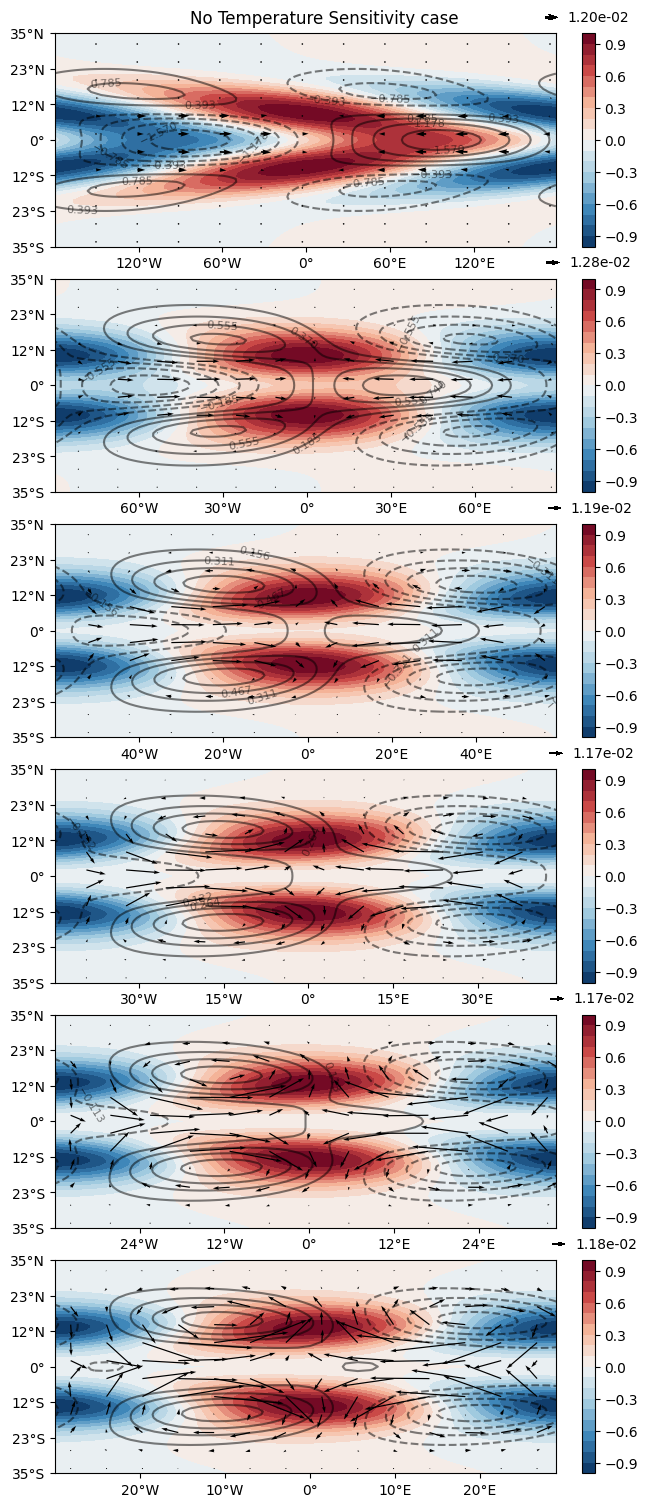

In [177]:
plt.style.use('default')
fig = plt.figure(figsize=(6, 16))
gs_main = gs.GridSpec(6, 2, width_ratios=[40,1], figure=fig)
gs_main.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.15, wspace=0.1)
fig.suptitle(t=f"{experiment_to_load} case", x=0.5, y=0.965)

day = 360

ax = []
cbar_ax = []
for row_index, k in enumerate([1,2,3,4,5,6]):
    xlims = (-180/k, 180/k)
    ylims = (-35, 35)
    
    ax.append(fig.add_subplot(gs_main[row_index,0]))
    cbar_ax.append(fig.add_subplot(gs_main[row_index,1]))

    scaling_factor = 1/np.max(multi_scale_output_variables['q'].sel(k=k).isel(time=day_to_index(day)))
    scaled_q = scaling_factor*multi_scale_output_variables['q'].sel(k=k).isel(time=day_to_index(day))
    scaled_T = scaling_factor*multi_scale_output_variables['T'].sel(k=k).isel(time=day_to_index(day))
    scaled_u = scaling_factor*multi_scale_output_variables['u'].sel(k=k).isel(time=day_to_index(day))
    scaled_v = scaling_factor*multi_scale_output_variables['v'].sel(k=k).isel(time=day_to_index(day))
    
    # moisture_zonal_argmax = np.argmax(scaled_q.sel(y=12*METERS_PER_DEGREE, method='nearest').values)
    [argy, argx] = np.unravel_index(np.argmax(scaled_q.values), [ny, nx])
    shift_value = -argx + nx//2
    # shift_value = 0
    
    CF = ax[row_index].contourf(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        np.roll(scaled_q, shift=shift_value, axis=1),
        cmap=Ahmed_cmap,
        norm=mcolors.CenteredNorm(vcenter=0),
        levels=21
    )
    cbar = plt.colorbar(CF, cax=cbar_ax[row_index])


    T_levels = np.delete(np.linspace(-1.1*np.max(np.abs(scaled_T)), 1.1*np.max(np.abs(scaled_T)), 11), [5])
    CS = ax[row_index].contour(
        output_zonal_gridpoints*grid_scaling,
        output_meridional_gridpoints*grid_scaling,
        np.roll(scaled_T, shift=shift_value, axis=1),
        levels=T_levels,
        colors='k',
        alpha=0.5
    )
    ax[row_index].clabel(CS, CS.levels, inline=False, fontsize=8, colors='k')

    # Find the indices of the left and right bounds of the plot 
    left_bound_index = np.abs(output_zonal_gridpoints/METERS_PER_DEGREE - xlims[0]).argmin()
    right_bound_index = np.abs(output_zonal_gridpoints/METERS_PER_DEGREE - xlims[1]).argmin()

    # Calculate the skip number necessary to give 'zonal_quiver_points' number of points
    n_skip_zonal = int(len(output_zonal_gridpoints[left_bound_index:right_bound_index])/12)

    # Find the indices of the bottom and top bounds of the plot 
    bottom_bound_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - ylims[0]).argmin()
    top_bound_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - ylims[1]).argmin()

    # Calculate the skip number necessary to give 'meridional_quiver_points' number of points
    n_skip_meridional = int(len(output_meridional_gridpoints[bottom_bound_index:top_bound_index])/11)
    
    quiv_scale = np.max(np.abs(scaled_u.values))
    quiv = ax[row_index].quiver(
        output_zonal_gridpoints[::n_skip_zonal]*grid_scaling,
        output_meridional_gridpoints[::n_skip_meridional]*grid_scaling,
        np.roll(-scaled_u, shift=shift_value, axis=1)[::n_skip_meridional,::n_skip_zonal],
        np.roll(-scaled_v, shift=shift_value, axis=1)[::n_skip_meridional,::n_skip_zonal],
        scale_units = 'xy',
        scale = quiv_scale
    )

    key_length = quiv_scale*(xlims[1]-xlims[0])/360
    key_label = f"{360/(xlims[1]-xlims[0])*quiv_scale:.2e}"
            
    ax[row_index].quiverkey(
        quiv,            
        xlims[1]*METERS_PER_DEGREE*grid_scaling, 1.15*(ylims[1]*METERS_PER_DEGREE*grid_scaling), 
        U=key_length,
        label=key_label,
        labelpos='E',          
        color='black', 
        labelcolor='black',
        coordinates='data'
    )
    
        
    longitude_ticks = np.arange(xlims[0]+xlims[1]/3, xlims[1]+xlims[1]/3, xlims[1]/3)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax[row_index].set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
    latitude_ticks = np.arange(ylims[0], ylims[1]+ylims[1]/3, ylims[1]/3)
    latitude_ticks[np.abs(latitude_ticks) < 0.5] = 0
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax[row_index].set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
    ax[row_index].set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,(xlims[1]-1)*METERS_PER_DEGREE*grid_scaling)
    ax[row_index].set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax[row_index].set_aspect('auto')

plt.show()

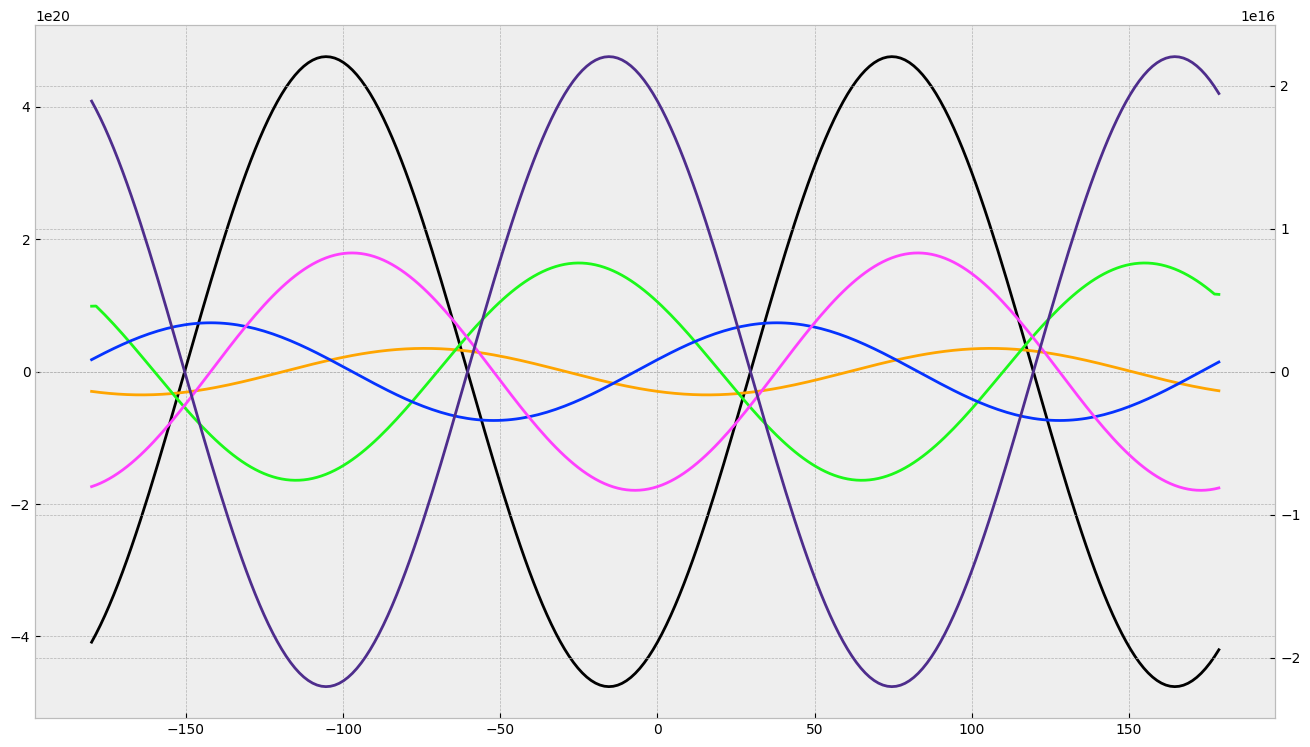

In [213]:
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

plt.style.use('bmh')
plt.figure(figsize=(16,9))
plt.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    multi_scale_output_variables["q"].sel(k=2, time=360*SECONDS_PER_DAY, y=25*METERS_PER_DEGREE, method='nearest'),
    color = 'black'
)

plt.twinx()

plt.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    multi_scale_output_variables["q"].differentiate(coord="time").sel(k=2, time=360*SECONDS_PER_DAY, y=25*METERS_PER_DEGREE, method='nearest'),
    color = bar_colors[0]
)

plt.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    gross_moisture_stratification*(
        multi_scale_output_variables["u"].differentiate(coord="x") + multi_scale_output_variables["v"].differentiate(coord="y")
    ).sel(k=2, time=360*SECONDS_PER_DAY, y=25*METERS_PER_DEGREE, method='nearest'),
    color = bar_colors[1]
)

plt.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    ZONAL_MOISTENING_PARAMETER*multi_scale_output_variables["u"].sel(k=2, time=360*SECONDS_PER_DAY, y=25*METERS_PER_DEGREE, method='nearest'),
    color = bar_colors[2]
)

plt.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    -(
        MERIDIONAL_MOISTENING_PARAMETER
        *(output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/gaussian_length_scale)**2))[None, None, :, None]
        *multi_scale_output_variables["v"]
    ).sel(k=2, time=360*SECONDS_PER_DAY, y=25*METERS_PER_DEGREE, method='nearest'),
    color = bar_colors[3]
)

plt.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE,
    -(
        MOISTURE_SENSITIVITY*multi_scale_output_variables["q"]
        - TEMPERATURE_SENSITIVITY*multi_scale_output_variables["T"]
    ).sel(k=2, time=360*SECONDS_PER_DAY, y=25*METERS_PER_DEGREE, method='nearest'),
    color = bar_colors[4]
)

plt.show()

In [208]:
test = multi_scale_output_variables["T"].assign_coords(
    day=("time", downsampled_timepoints/SECONDS_PER_DAY),
    lat=("y", output_meridional_gridpoints/METERS_PER_DEGREE),
    lon=("x", output_zonal_gridpoints/METERS_PER_DEGREE)
).swap_dims({"time":"day", "y":"lat", "x":"lon"})

test.sel(day=360, method='nearest')

<xarray.DataArray 'T' (k: 6, lat: 128, lon: 256)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.61532385e+06,  4.88275760e+06,  5.14725017e+06, ...,
          3.79699463e+06,  4.07227880e+06,  4.34510999e+06],
        [ 6.87669427e+06,  7.49615146e+06,  8.11109325e+06, ...,
          4.99497392e+06,  5.62572874e+06,  6.25309482e+06],
        ...,
        [ 9.26807705e+06,  1.01513746e+07,  1.10285573e+07, ...,
          6.58683274e+06,  7.48526918e+06,  8.37919677e+06],
        [ 2.18311328e+06,  2.61230677e+06,  3.03992671e+06, ...,
          8.88680575e+05,  1.32104054e+06,  1.75260476e+06],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.09012854e+16,  4.19787346e+16,  4.29550535e+16, ...,
          3.70892916e+16,  3.84536155e+16,  3.97253013e+16],
        [ 8.84367195e+16,  9.09676270e+16,  9.32793855e+16, ...,
          7.95926254e+16,  8.27423596e+16,  8.56927602e+16],
...
        [-4.27113216e+46, -3.92176192e+46, -3.51340472e+46, ...,
         -4.91766845e+46, -4.77285865e+46, -4.55626060e+46],
        [-2.17884515e+46, -2.05037369e+46, -1.89106271e+46, ...,
         -2.36238529e+46, -2.33603308e+46, -2.27454475e+46],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.55140610e+51, -3.77345499e+51, -3.91381998e+51, ...,
         -2.45140360e+51, -2.88314752e+51, -3.25247999e+51],
        [-7.31905067e+51, -7.88103690e+51, -8.27242249e+51, ...,
         -4.74795177e+51, -5.73536712e+51, -6.59862909e+51],
        ...,
        [-1.03708693e+52, -1.12530982e+52, -1.18917314e+52, ...,
         -6.47736501e+51, -7.95687488e+51, -9.26414245e+51],
        [-4.16239878e+51, -4.71552087e+51, -5.16656617e+51, ...,
         -2.01975695e+51, -2.79976840e+51, -3.51917333e+51],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * k        (k) int64 1 2 3 4 5 6
    time     float64 3.108e+07
    y        (lat) float64 -7e+06 -6.891e+06 -6.781e+06 ... 6.781e+06 6.891e+06
    x        (lon) float64 -2.002e+07 -1.986e+07 ... 1.97e+07 1.986e+07
    day      float64 359.7
  * lat      (lat) float64 -62.95 -61.97 -60.99 -60.0 ... 59.02 60.0 60.99 61.97
  * lon      (lon) float64 -180.0 -178.6 -177.2 -175.8 ... 175.8 177.2 178.6

## epsq/epst ratio

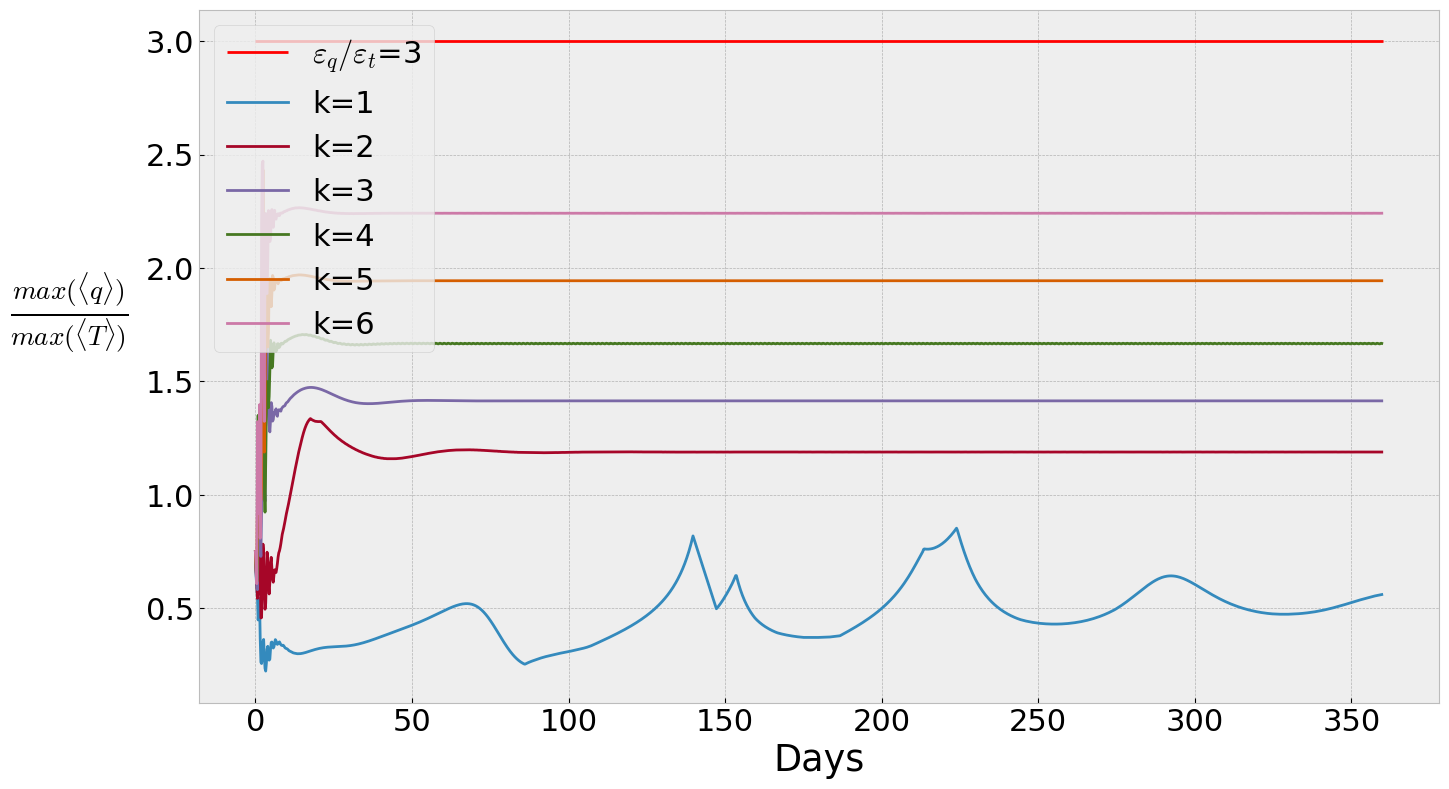

In [303]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16,9))

plt.hlines(y=3, xmin=0, xmax=360, label=r'$\varepsilon_q/\varepsilon_t$=3', color='red')
# for data_variable in multi_scale_output_variables.data_vars:
for k in multi_scale_output_variables["k"].values: 
    max_value_ratio = multi_scale_output_variables["q"].sel(k=k).max(dim=["y", "x"])/multi_scale_output_variables["T"].sel(k=k).max(dim=["y", "x"])
    plt.plot(
        downsampled_timepoints/SECONDS_PER_DAY,
        max_value_ratio,
        label=f"k={k}"
    )

plt.ylabel(r'$\frac{max(\langle q \rangle)}{max(\langle T \rangle)}$', rotation=0, labelpad=55, fontsize=28)
plt.xlabel('Days')
plt.legend(loc='best')
plt.show()

## Compare budgets

### Growth Budgets

#### Single time

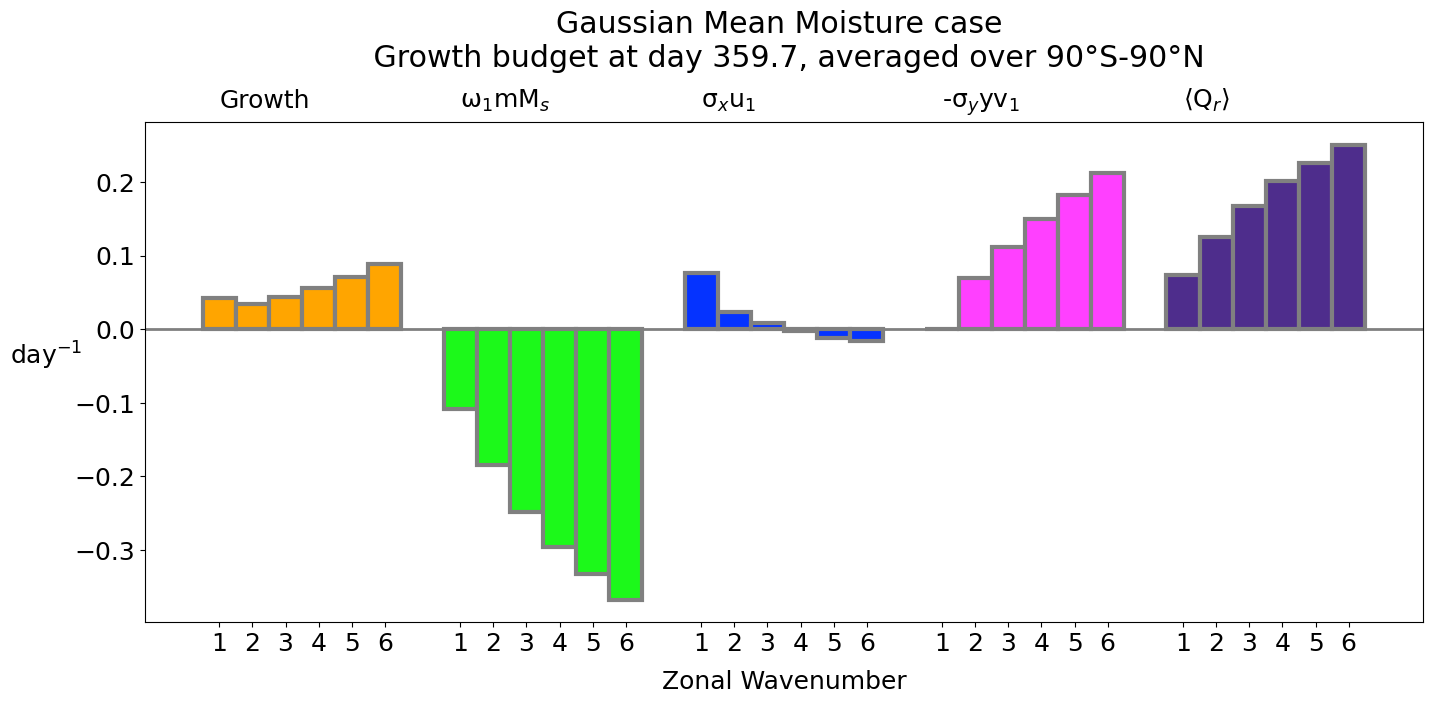

In [79]:
# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

# bar_labels = [r'Growth', r'ω$_1$mM$_s$ + $\langle$Q$_r$$\rangle$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$']
# bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff']

south_bound = multi_scale_growth_budgets.attrs['Latitude Bounds'][0]
north_bound = multi_scale_growth_budgets.attrs['Latitude Bounds'][1]

width = 0.1375
multiplier = 0
x = np.arange(len(bar_labels))

t = day_to_index(360)

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
bar_max = []
for k in multi_scale_growth_budgets["k"]:
    offset = width * multiplier
    bar_values = [
            SECONDS_PER_DAY*multi_scale_growth_budgets['growth'].sel(k=k).isel(time=t),
            SECONDS_PER_DAY*multi_scale_growth_budgets['omega'].sel(k=k).isel(time=t),
            SECONDS_PER_DAY*multi_scale_growth_budgets['u'].sel(k=k).isel(time=t),
            SECONDS_PER_DAY*multi_scale_growth_budgets['v'].sel(k=k).isel(time=t),
            SECONDS_PER_DAY*multi_scale_growth_budgets['Qr'].sel(k=k).isel(time=t)
        ]
    bar_max.append(np.max(bar_values))
    
    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = exp, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

for l in range(len(bar_labels)):
    ax.text(l, 1.2*np.max(bar_max), s=bar_labels[l])

ax.axhline(y = 0, color='gray', lw=2)

ax.set_title(
    f"{experiment_to_load} case \n Growth budget at day {downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}," 
    + f" averaged over {mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}",
    pad=40
) 
# ax.set_ylim(-0.01, 0.01)
ax.set_xticks(
    np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
    sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
)
ax.set_ylabel(r'day$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Zonal Wavenumber', labelpad=10)
# ax.legend()
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_multi-scale_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

#### Animation

 99%|████████████████████████████████████████████████████████████▋| 180/181 [01:36<00:00,  2.01it/s]

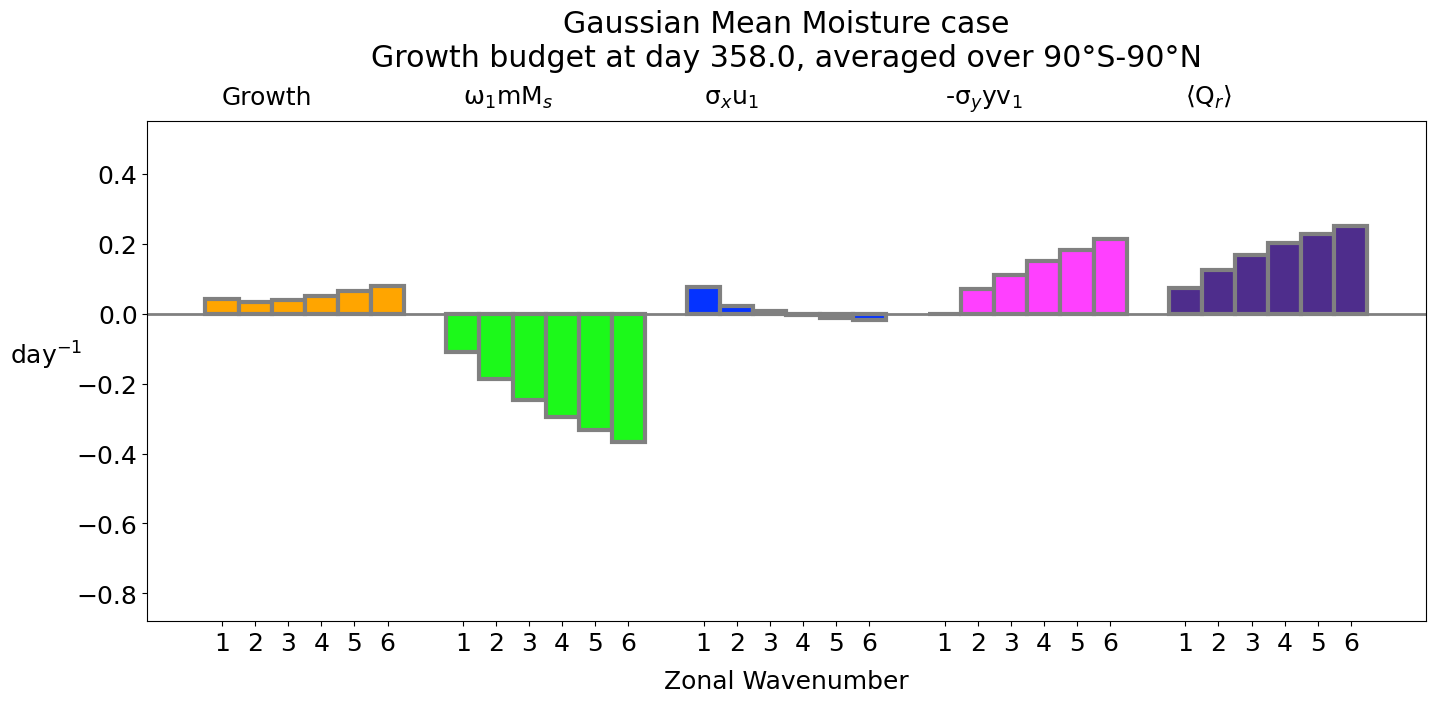

In [80]:
starting_frame = day_to_index(2)
ending_frame = day_to_index(360)
frame_interval = day_to_index(2)

south_bound = multi_scale_growth_budgets.attrs['Latitude Bounds'][0]
north_bound = multi_scale_growth_budgets.attrs['Latitude Bounds'][1]

# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

wavenumber_max = []
wavenumber_min = []
for k in multi_scale_growth_budgets["k"]:
    wavenumber_max.append(
        np.max(
            (
                multi_scale_growth_budgets['growth'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['omega'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['u'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['v'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['Qr'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
            )
        )
    )
    wavenumber_min.append(
        np.min(
            (
                multi_scale_growth_budgets['growth'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['omega'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['u'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['v'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
                multi_scale_growth_budgets['Qr'].sel(k=k).isel(time=slice(starting_frame, ending_frame)),
            )
        )
    )

grand_max = np.max(wavenumber_max)*SECONDS_PER_DAY
grand_min = np.min(wavenumber_min)*SECONDS_PER_DAY

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))

def update(frame):
    # Set the bar width
    width = 0.1375
    multiplier = 0
    x = np.arange(len(bar_labels))

    ax.clear()
    
    bar_max = []
    for k in multi_scale_growth_budgets["k"]:
        offset = width * multiplier
        bar_values = [
                SECONDS_PER_DAY*multi_scale_growth_budgets['growth'].sel(k=k).isel(time=frame),
                SECONDS_PER_DAY*multi_scale_growth_budgets['omega'].sel(k=k).isel(time=frame),
                SECONDS_PER_DAY*multi_scale_growth_budgets['u'].sel(k=k).isel(time=frame),
                SECONDS_PER_DAY*multi_scale_growth_budgets['v'].sel(k=k).isel(time=frame),
                SECONDS_PER_DAY*multi_scale_growth_budgets['Qr'].sel(k=k).isel(time=frame),
            ]
        bar_max.append(np.max(bar_values))
        
        rects = ax.bar(
            x + offset, 
            bar_values, 
            label = k, 
            color = bar_colors, 
            width = width,
            edgecolor='gray', 
            linewidth=3,
            align='center'
        )    
        # ax.bar_label(rects, padding=0.3)
        multiplier += 1
    
    for l in range(len(bar_labels)):
        # ax.text(l, 1.2*np.max(bar_max), s=bar_labels[l])
        ax.text(l, 0.05+1.1*round_out(grand_max, 'tenths'), s=bar_labels[l])
    
    ax.axhline(y = 0, color='gray', lw=2)
    
    ax.set_title(
        f"{experiment_to_load} case\nGrowth budget at day {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f}," 
        + f" averaged over {mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}",
        pad=40
    ) 
    ax.set_xticks(
        np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
        sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
    )
    ax.set_ylabel(r'day$^{-1}$', rotation=0, labelpad=22)
    ax.set_xlabel('Zonal Wavenumber', labelpad=10)
    ax.set_ylim(1.1*round_out(grand_min, 'tenths'), 1.1*round_out(grand_max, 'tenths'))

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300,
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{initial_condition_type}-initial-condition_multi-scale_growth-budget_animation"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=150,
)

### Propagation Budgets

#### Single time

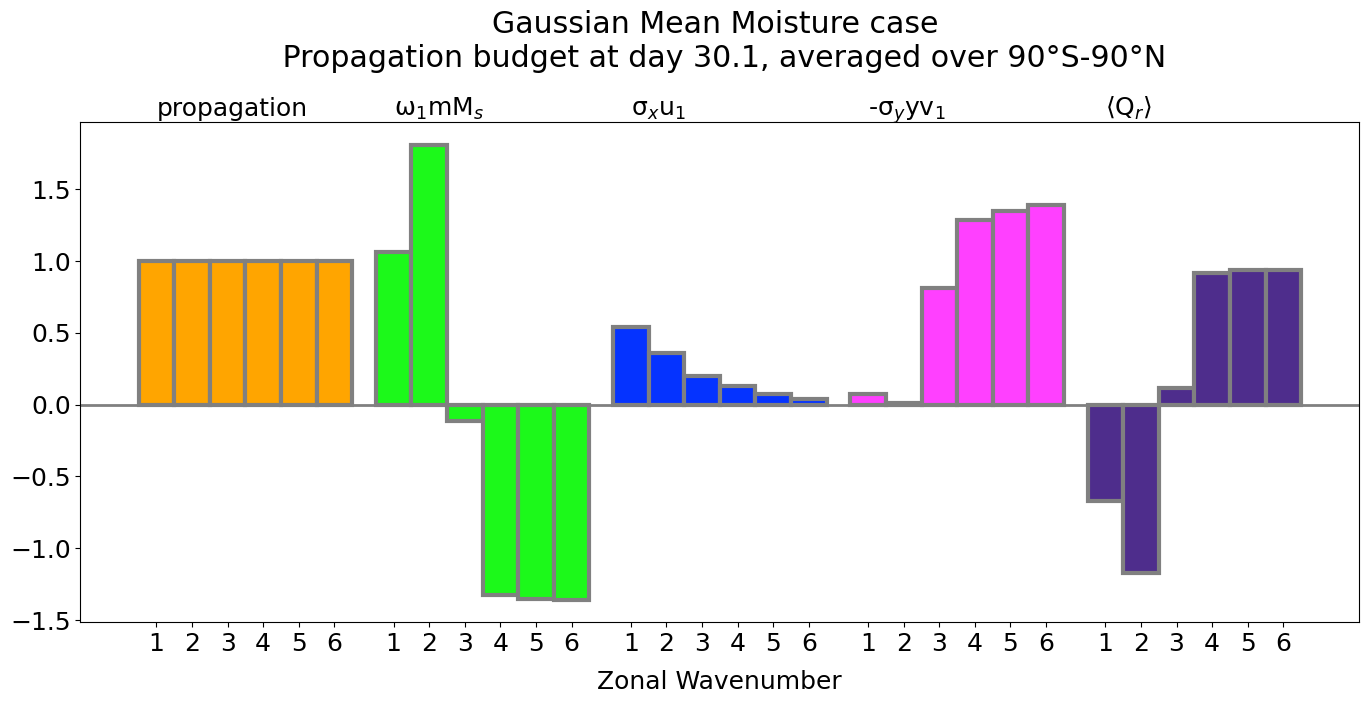

In [78]:
# Label the bars 
bar_labels = [r'propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

south_bound = multi_scale_propagation_budgets.attrs['Latitude Bounds'][0]
north_bound = multi_scale_propagation_budgets.attrs['Latitude Bounds'][1]

width = 0.15
multiplier = 0
x = np.arange(len(bar_labels))

# y_max = 2.25

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
bar_max = []
t = day_to_index(30)
for k in multi_scale_propagation_budgets["k"]:
    
    offset = width * multiplier
    bar_values = [
            multi_scale_propagation_budgets['propagation'].sel(k=k).isel(time=t),
            multi_scale_propagation_budgets['omega'].sel(k=k).isel(time=t),
            multi_scale_propagation_budgets['u'].sel(k=k).isel(time=t),
            multi_scale_propagation_budgets['v'].sel(k=k).isel(time=t),
            multi_scale_propagation_budgets['Qr'].sel(k=k).isel(time=t)
        ]
    bar_max.append(np.max(bar_values))
    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = exp, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

for l in range(len(bar_labels)):
    ax.text(l, 0.2+np.max(bar_max), s=bar_labels[l])

ax.axhline(y = 0, color='gray', lw=2)

ax.set_title(
    f"{experiment_to_load} case \n Propagation budget at day {downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}," 
    + f" averaged over {mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}",
    pad=40
) 
ax.set_xticks(
    np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
    sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
)
# ax.set_ylabel(r's$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Zonal Wavenumber', labelpad=10)
# ax.legend()
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_multi-scale_multi_scale_propagation-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

#### Animation

 99%|████████████████████████████████████████████████████████████▋| 180/181 [01:28<00:00,  2.12it/s]

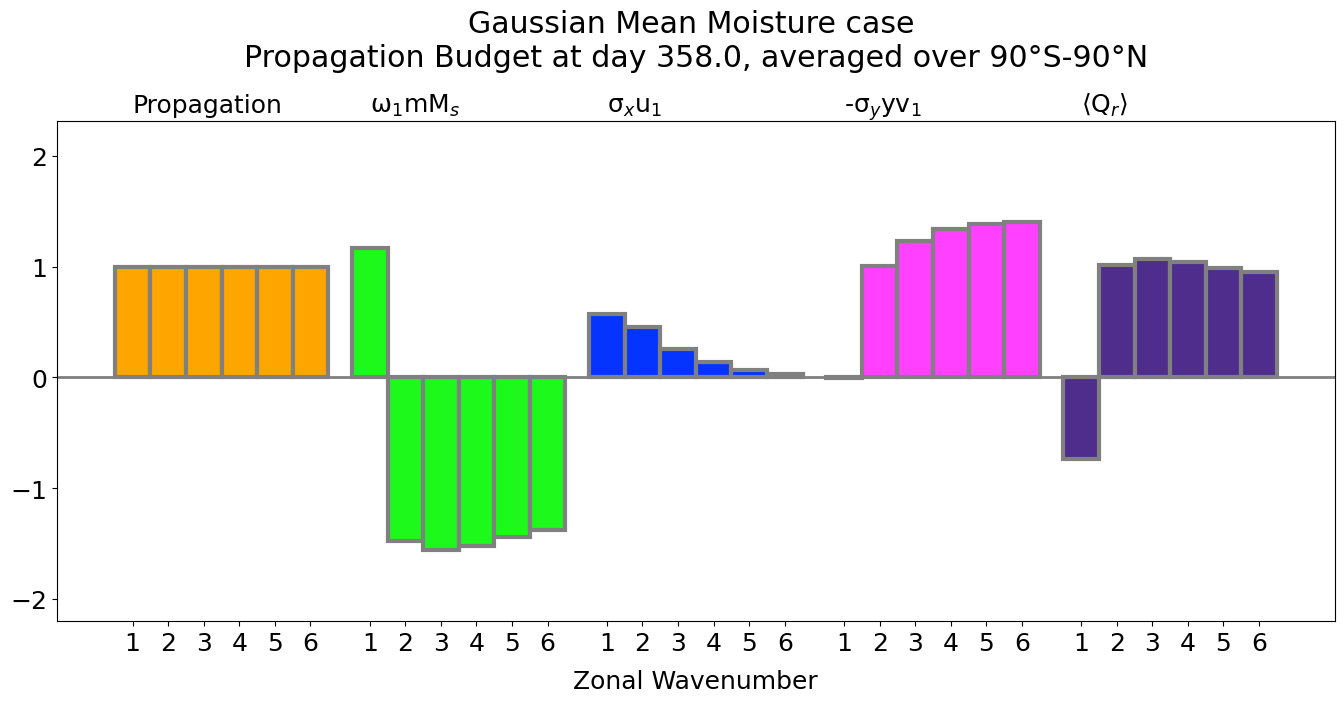

In [81]:
starting_frame = day_to_index(2)
ending_frame = day_to_index(360)
frame_interval = day_to_index(2)

# Label the bars 
bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

south_bound = multi_scale_propagation_budgets.attrs['Latitude Bounds'][0]
north_bound = multi_scale_propagation_budgets.attrs['Latitude Bounds'][1]

wavenumber_max = []
wavenumber_min = []
for k in multi_scale_propagation_budgets["k"]:
    wavenumber_max.append(
        np.max(
            (
                multi_scale_propagation_budgets['propagation'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['omega'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['u'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['v'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['Qr'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
            )
        )
    )
    wavenumber_min.append(
        np.min(
            (
                multi_scale_propagation_budgets['propagation'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['omega'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['u'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['v'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
                multi_scale_propagation_budgets['Qr'].sel(k=k).isel(time=slice(starting_frame,ending_frame)),
            )
        )
    )

grand_max = np.max(wavenumber_max)
grand_min = np.min(wavenumber_min)

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))

def update(frame):
    # Set the bar width
    width = 0.15
    multiplier = 0
    x = np.arange(len(bar_labels))

    ax.clear()
    
    bar_max = []
    for k in multi_scale_propagation_budgets["k"]:
        offset = width * multiplier
        bar_values = [
            multi_scale_propagation_budgets['propagation'].sel(k=k).isel(time=frame),
            multi_scale_propagation_budgets['omega'].sel(k=k).isel(time=frame),
            multi_scale_propagation_budgets['u'].sel(k=k).isel(time=frame),
            multi_scale_propagation_budgets['v'].sel(k=k).isel(time=frame),
            multi_scale_propagation_budgets['Qr'].sel(k=k).isel(time=frame),
            ]
        bar_max.append(np.max(bar_values))
        
        rects = ax.bar(
            x + offset, 
            bar_values, 
            label = k, 
            color = bar_colors, 
            width = width,
            edgecolor='gray', 
            linewidth=3,
            align='center'
        )    
        # ax.bar_label(rects, padding=0.3)
        multiplier += 1
    
    for l in range(len(bar_labels)):
        # ax.text(l, 1.2*np.max(bar_max), s=bar_labels[l])
        ax.text(l, 0.08+1.1*round_out(grand_max, 'tenths'), s=bar_labels[l])
    
    ax.axhline(y = 0, color='gray', lw=2)
    
    ax.set_title(
        f"{experiment_to_load} case \nPropagation Budget at day {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f}," 
        + f" averaged over {mjo.tick_labeller([south_bound], 'lat')[0]}-{mjo.tick_labeller([north_bound], 'lat')[0]}",
        pad=40
    ) 
    ax.set_xticks(
        # np.concatenate((x, x+offset/3, x+2*offset/3, x+offset)),
        np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
        sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
    )
    # ax.set_ylabel(r'day$^{-1}$', rotation=0, labelpad=22)
    ax.set_xlabel('Zonal Wavenumber', labelpad=10)
    # ax.set_ylim(-2, 2)
    ax.set_ylim(1.1*round_out(grand_min, 'tenths'), 1.1*round_out(grand_max, 'tenths'))

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300,
)

anim.save(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
    + f"{initial_condition_type}-initial-condition_multi-scale_propagation-budget_animation"
    + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
    + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
    + f".mp4", 
    dpi=150,
)

## Phase speeds

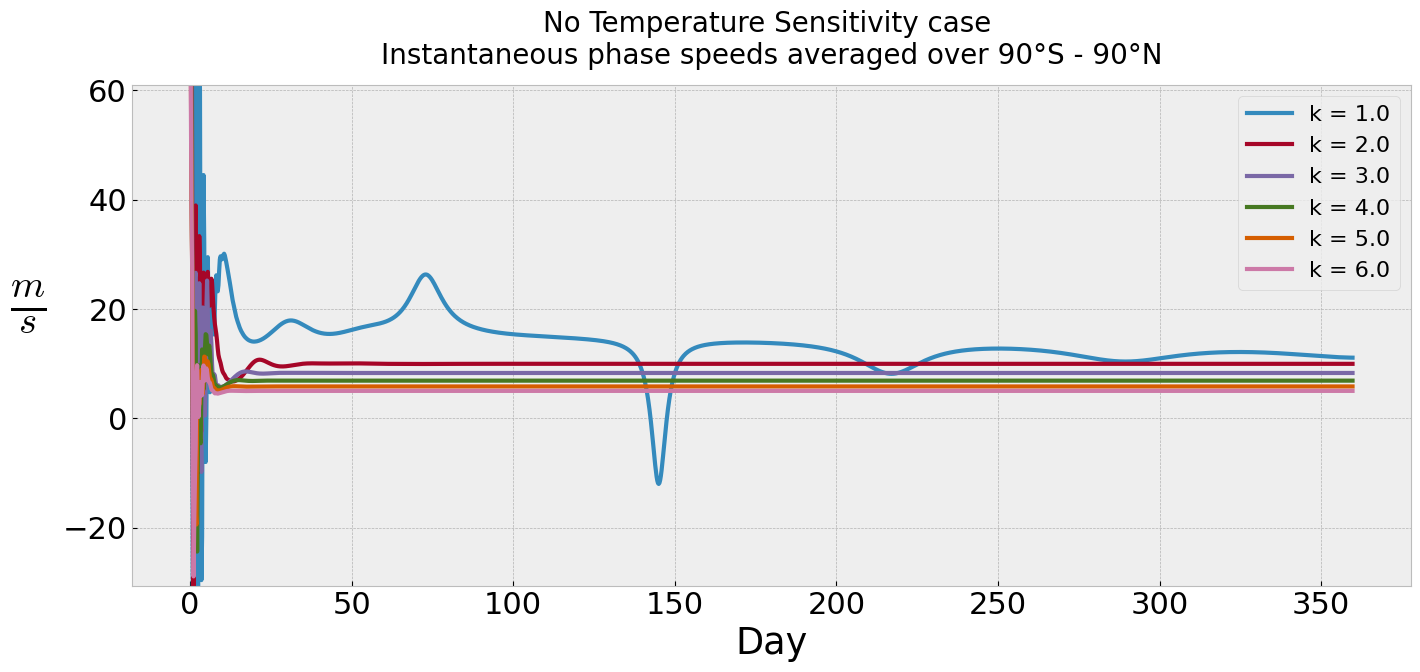

In [95]:
grand_max = []
grand_min = []

south_bound = multi_scale_phase_speeds.attrs['Latitude Bounds'][0]
north_bound = multi_scale_phase_speeds.attrs['Latitude Bounds'][1]

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
for k in multi_scale_phase_speeds["k"]:
    ax.plot(
        downsampled_timepoints/SECONDS_PER_DAY, 
        multi_scale_phase_speeds.sel(k=k),
        label=f"k = {k:0.1f}", 
        lw=3
    )

    grand_max.append(multi_scale_phase_speeds.sel(k=k).isel(time=slice(day_to_index(3), day_to_index(360))).max())
    grand_min.append(multi_scale_phase_speeds.sel(k=k).isel(time=slice(day_to_index(3), day_to_index(360))).min())

grand_max = np.max(grand_max)
grand_min = np.min(grand_min)

ax.set_ylim(grand_min-1, grand_max+1)
ax.set_title(
    f"{experiment_to_load} case \nInstantaneous phase speeds averaged over "
    + f"{np.abs(multi_scale_phase_speeds[index].attrs['Latitude Bounds'][0])}°S"
    + f" - {np.abs(multi_scale_phase_speeds[index].attrs['Latitude Bounds'][1])}°N", 
    pad=15,
    fontsize=20
)
ax.set_xlabel('Day')
ax.set_ylabel(r'$\frac{m}{s}$', rotation=0, labelpad=25, fontsize=40)
ax.legend(fontsize=16)
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
#     + f"{initial_condition_type}-initial-condition_multi-scale_instantaneous-phase-speeds"
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
#     (+ f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Pattern correlations

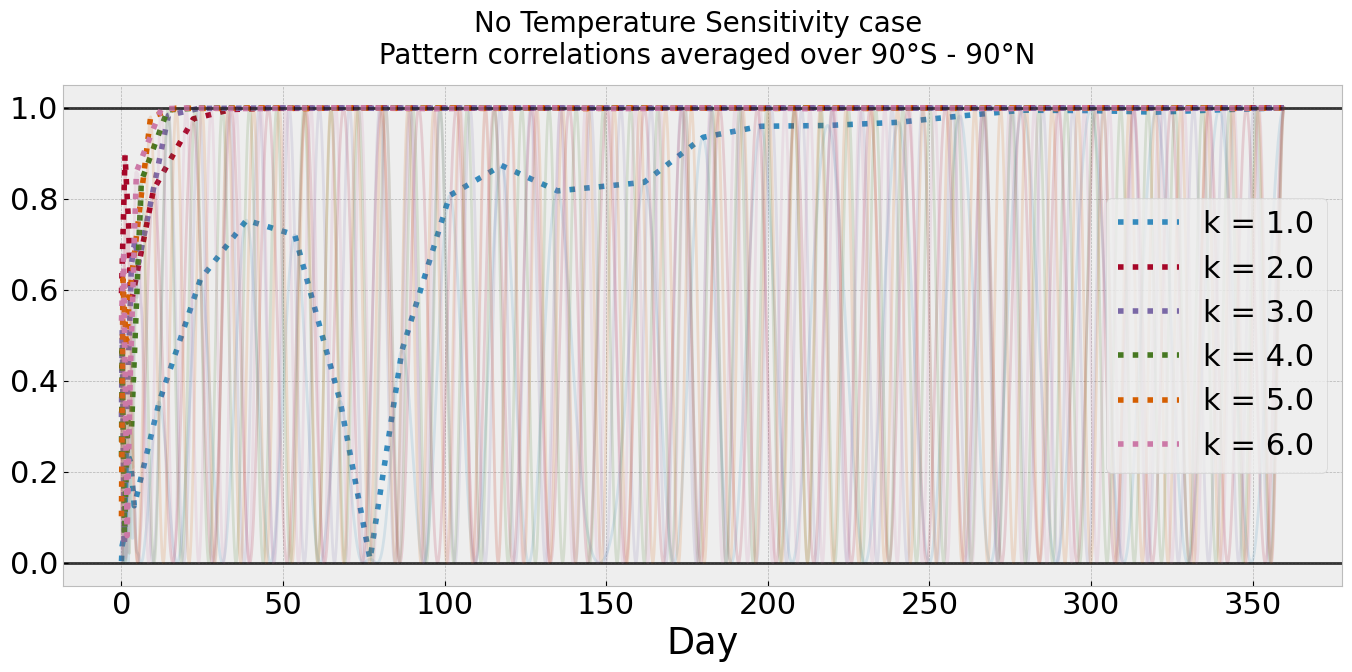

In [96]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
for k in multi_scale_pattern_correlations["k"]:
    peaks = sp.signal.find_peaks(multi_scale_pattern_correlations.sel(k=k)**2)[0]
    padded_peaks = np.insert(peaks, 0, 0)
    padded_peaks = np.append(padded_peaks, len(downsampled_timepoints)-1)
    
    # ax.plot(
    # pattern_correlations[exp]['time']/SECONDS_PER_DAY, 
    # pattern_correlations[exp],
    # label=f"k = {(index+1):0.1f}", 
    # lw=3
    # )

    ax.plot(
        downsampled_timepoints/SECONDS_PER_DAY, 
        multi_scale_pattern_correlations.sel(k=k)**2, 
        color=bmh_colors(int(k)),
        lw=2,
        # label=f"k = {(index+1):0.1f}", 
        alpha=0.15
    )
    
    ax.plot(
        downsampled_timepoints[padded_peaks]/SECONDS_PER_DAY, 
        multi_scale_pattern_correlations.sel(k=k)[padded_peaks]**2, 
        color=bmh_colors(int(k)),
        lw=4,
        ls=':',
        label=f"k = {k:0.1f}", 
    )
    
    ax.axhline(y=0, color='k', alpha=0.2)
    ax.axhline(y=1, color='k', alpha=0.2)

# ax.set_xlim(10, 100)
# ax.set_ylim(-1, 1.05)
ax.set_title(
    f"{experiment_to_load} case \n Pattern correlations averaged over "
    + f"{np.abs(multi_scale_pattern_correlations.attrs['Latitude Bounds'][0])}°S"
    + f" - {np.abs(multi_scale_pattern_correlations.attrs['Latitude Bounds'][1])}°N", 
    pad=15,
    fontsize=20
)
ax.set_xlabel('Day')
# ax.set_ylabel(r'$\frac{m}{s}$', rotation=0, labelpad=25, fontsize=40)
ax.legend()
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_multi-scale_pattern-correlation"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Dispersion curves

In [ ]:
A21_frequencies = [0.103609, 0.181382, 0.265887, 0.356728, 0.453978]

starting_day = 3
ending_day = 100

# Plot dispersion curves
calculated_frequency = []
for k in multi_scale_phase_speeds["k"]:
    calculated_frequency.append(
        np.mean(
            multi_scale_phase_speeds.sel(k=k).isel(time=slice(day_to_index(starting_day),day_to_index(ending_day)))*(k/EARTH_RADIUS)
        )
    )
    # calculated_frequency.append(phase_speeds[exp][t]*(index+1)/EARTH_RADIUS)

plt.style.use('bmh')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title(f"Dispersion curve, averaged over days {starting_day}-{ending_day}")

ax.plot(
    np.array([1,2,3,4,5,6]),
    SECONDS_PER_DAY*np.array(calculated_frequency), marker='o'
)


ax.plot([1,2,3,4,5], A21_frequencies, label='Ahmed 21', marker='o', color='red')
ax.set_xlabel('Wavenumber')
ax.set_xticks(ticks=np.array([1,2,3,4,5,6]), labels=np.array([1,2,3,4,5,6]))
frequency_ticks = np.arange(0, 0.6, 0.1)
ax.set_ylabel(r'Frequency (day$^{-1}$)')
ax.set_ylim(0, 0.6)
ax.set_yticks(ticks=frequency_ticks)
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax.get_shared_y_axes().join(ax, ax2)

ax2.set_ylim(0, 0.6)
# period_ticks = [2*np.pi/120, 2*np.pi/30, 2*np.pi/12]
period_tick_labels = [f"{2*np.pi/tick:0.0f}" for tick in frequency_ticks[1:]]
ax2.set_yticks(ticks=frequency_ticks[1:], labels=period_tick_labels)
ax2.set_ylabel('Period (day)')


plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_dispersion-curve-plot"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

# Compare across experiments

In [56]:
# print(f"    Multi-experiment data         ")
print(f"{'Multi-experiment data':^50}")
save_timestamp = False

experiments_to_load = [
    # 'Base Case',
    'Gaussian Mean Moisture',
    'Variable Moisture Sensitivity',
    'No Temperature Sensitivity',
    'Quadratic-No Temperature Sensitivity'
]

print(f"{'':{'='}^{50}}")
print("Loading grid variables...")
k = 1
specified_initial_condition_name = f"k={k}.0_m=1_Kelvin-wave"
initial_condition_type = specified_initial_condition_name.split('_')[-1]

specified_output_file_directory = f"output/Ahmed-21/{experiments_table[experiments_to_load[1]]}"

downsampled_data = xr.load_dataset(
    f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
    + f"{specified_initial_condition_name}" 
    + f"_downsampled-model-data_compiled.nc"
)

output_zonal_gridpoints = downsampled_data.x.to_numpy()
output_meridional_gridpoints = downsampled_data.y.to_numpy()
downsampled_timepoints = downsampled_data.time.to_numpy()
print("Grid variables loaded")
print(f"{'':{'='}^{50}}")

print("Loading experiment variables...")
#### Load experiment variables
with open(
    f"{specified_output_file_directory}/experiment_variables.json", 'r') as json_file:
    loaded_experiment_variables = json.load(json_file)

simulation_moisture = loaded_experiment_variables['simulation_moisture']
moisture_advection = loaded_experiment_variables['moisture_advection']
simulation_damping = loaded_experiment_variables['simulation_damping']
moisture_coupling = loaded_experiment_variables['moisture_coupling']
simulation_diffusion = loaded_experiment_variables['simulation_diffusion']
fringe_region = loaded_experiment_variables['fringe_region']
moisture_sensitivity_structure = loaded_experiment_variables['moisture_sensitivity_structure']
temperature_sensitivity_structure = loaded_experiment_variables['temperature_sensitivity_structure']
mean_moisture_profile = loaded_experiment_variables['mean_moisture_profile']
gaussian_length_scale = loaded_experiment_variables['moisture_length_scale']
GRAVITY = loaded_experiment_variables['GRAVITY']
EQUIVALENT_DEPTH = loaded_experiment_variables['EQUIVALENT_DEPTH']
CORIOLIS_PARAMETER = loaded_experiment_variables['CORIOLIS_PARAMETER']
EARTH_RADIUS = loaded_experiment_variables['EARTH_RADIUS']
AIR_DENSITY = loaded_experiment_variables['AIR_DENSITY']
WATER_DENSITY = loaded_experiment_variables['WATER_DENSITY']
LATENT_HEAT = loaded_experiment_variables['LATENT_HEAT']
SPECIFIC_HEAT = loaded_experiment_variables['SPECIFIC_HEAT']
DIFFUSIVITY = loaded_experiment_variables['DIFFUSIVITY']
METERS_PER_DEGREE = loaded_experiment_variables['METERS_PER_DEGREE']
SECONDS_PER_DAY = loaded_experiment_variables['SECONDS_PER_DAY']
COLUMN_AVERAGE_MASS = loaded_experiment_variables['COLUMN_AVERAGE_MASS']
GROSS_DRY_STABILITY = loaded_experiment_variables['GROSS_DRY_STABILITY']
MOISTURE_SENSITIVITY = loaded_experiment_variables['MOISTURE_SENSITIVITY']
TEMPERATURE_SENSITIVITY = loaded_experiment_variables['TEMPERATURE_SENSITIVITY']
CLOUD_RADIATIVE_PARAMETER = loaded_experiment_variables['CLOUD_RADIATIVE_PARAMETER']
sigma_x_multiplier = loaded_experiment_variables['sigma_x_multiplier']
sigma_y_multiplier = loaded_experiment_variables['sigma_y_multiplier']
ZONAL_MOISTENING_PARAMETER = loaded_experiment_variables['ZONAL_MOISTENING_PARAMETER']
MERIDIONAL_MOISTENING_PARAMETER = loaded_experiment_variables['MERIDIONAL_MOISTENING_PARAMETER']
MERIDIONAL_OFFSET_PARAMETER = loaded_experiment_variables['MERIDIONAL_OFFSET_PARAMETER']
gravity_wave_phase_speed = loaded_experiment_variables['gravity_wave_phase_speed']
time_scale = loaded_experiment_variables['time_scale']
length_scale = loaded_experiment_variables['length_scale']
gross_moisture_stratification = loaded_experiment_variables['gross_moisture_stratification']
effective_sensitivity = loaded_experiment_variables['effective_sensitivity']
effective_gross_moist_stability = loaded_experiment_variables['effective_gross_moist_stability']
scaled_zonal_parameter = loaded_experiment_variables['scaled_zonal_parameter']
scaled_meridional_parameter = loaded_experiment_variables['scaled_meridional_parameter']
n_days = loaded_experiment_variables['n_days']
n_chunks = loaded_experiment_variables['n_chunks']
n_time_steps = loaded_experiment_variables['n_time_steps']
meridional_domain_length = loaded_experiment_variables['meridional_domain_length']
zonal_domain_length = loaded_experiment_variables['zonal_domain_length']
nt = loaded_experiment_variables['nt']    
nx = loaded_experiment_variables['nx']
ny = loaded_experiment_variables['ny']
zonal_grid_spacing = loaded_experiment_variables['zonal_grid_spacing']
meridional_grid_spacing = loaded_experiment_variables['meridional_grid_spacing']
simulation_length = loaded_experiment_variables['simulation_length']
time_step = loaded_experiment_variables['time_step']
zonal_step_size = loaded_experiment_variables['zonal_step_size']
meridional_step_size = loaded_experiment_variables['meridional_step_size']
CFL_x = loaded_experiment_variables['CFL_x']
CFL_y = loaded_experiment_variables['CFL_y']
fringe_region_latitude = loaded_experiment_variables['fringe_region_latitude']
fringe_region_width = loaded_experiment_variables['fringe_region_width']
fringe_region_strength = loaded_experiment_variables['fringe_region_strength']
grid_scaling = loaded_experiment_variables['grid_scaling']
additional_notes = loaded_experiment_variables['additional_notes']
simulation_name = loaded_experiment_variables['simulation_name']
output_file_directory = loaded_experiment_variables['output_file_directory']
n_rk_steps = loaded_experiment_variables['n_rk_steps']
save_downsampled = loaded_experiment_variables['save_downsampled']

# output_wavenumber = eval(specified_initial_condition_name.split('_')[0].split('=')[-1])/EARTH_RADIUS
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

print("Experiment variables loaded")
print(f"{'':{'='}^{50}}")

#### Initialize data metric arrays
multi_experiment_growth_budgets = xr.Dataset(
    data_vars=dict(
        growth=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        omega=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        u=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        v=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        Qr=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        D=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        residual=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
), 
    coords=dict(
        experiment=experiments_to_load,
        k=[1,2,3,4,5,6], 
        time=downsampled_timepoints
    ), 
    attrs = {'Latitude Bounds':(None, None)}
)

multi_experiment_propagation_budgets = xr.Dataset(
    data_vars=dict(
        propagation=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        omega=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        u=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        v=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        Qr=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        D=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
        residual=(["experiment", "k", "time"], np.empty((len(experiments_to_load), 6, len(downsampled_timepoints)))),
), 
    coords=dict(
        experiment=experiments_to_load,
        k=[1,2,3,4,5,6], 
        time=downsampled_timepoints
    ), 
    attrs = {'Latitude Bounds':(None, None)}
)

multi_experiment_phase_speeds = xr.DataArray(
    None, 
    coords=dict(
        # experiment=[experiments_table[experiment] for experiment in experiments_to_load],
        experiment=experiments_to_load,
        k=[1,2,3,4,5,6], 
        time=downsampled_timepoints
    ), 
    dims=("experiment", "k", "time"),
    attrs = {'Latitude Bounds':(None, None)}
)

south_bound = -90
north_bound = 90

print(f"{'Loading experiment data...':<50}")
for experiment_index, experiment in enumerate(experiments_to_load):
    print(f"---- Experiment: {experiment}")
    for k_index, k in enumerate([1,2,3,4,5,6]):
        specified_initial_condition_name = f"k={k}.0_m=1_Kelvin-wave"
        specified_output_file_directory = f"output/Ahmed-21/{experiments_table[experiment]}"

        for budget_variable in multi_experiment_growth_budgets.data_vars:
            # Load the growth budget dataset for the current initial condition
            loaded_growth_budget = xr.load_dataset(
                f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
                + f"{specified_initial_condition_name}_MSE-growth-budget"
                + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
                )
    
            # Assign the loaded growth budget to the initialized dataset
            multi_experiment_growth_budgets[budget_variable][experiment_index, k_index] = loaded_growth_budget[budget_variable]
            multi_experiment_growth_budgets.attrs['Latitude Bounds'] = loaded_growth_budget.attrs['Latitude Bounds']
            
        for budget_variable in multi_experiment_propagation_budgets.data_vars:
            # Load the propagation budget dataset for the current initial condition
            loaded_propagation_budget = xr.load_dataset(
                f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/"
                + f"{specified_initial_condition_name}_MSE-propagation-budget"
                + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
                )
    
            # Assign the loaded propagation budget to the initialized dataset
            multi_experiment_propagation_budgets[budget_variable][experiment_index, k_index] = loaded_propagation_budget[budget_variable]
            multi_experiment_propagation_budgets.attrs['Latitude Bounds'] = loaded_propagation_budget.attrs['Latitude Bounds']
            
            
        loaded_phase_speeds = xr.load_dataarray(
            f"{specified_output_file_directory}/Kelvin-wave_initial-condition/"
            + f"{specified_initial_condition_name}_instantaneous-phase-speed"
            + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}.nc"
            )

        if experiment == 'Base Case':
            print("-------- Interpolating base case phase speeds...")
            subset_loaded_phase_speeds = loaded_phase_speeds.sel(time=slice(0, 360*SECONDS_PER_DAY))
            interpolated_phase_speeds = subset_loaded_phase_speeds.interp(time=downsampled_timepoints)
            loaded_phase_speeds = interpolated_phase_speeds.copy(deep=True)
            print("-------- Phase speeds interpolated")
            # print(f"{'':{'='}^{50}}")
    
        multi_experiment_phase_speeds[experiment_index, k_index] = loaded_phase_speeds
        multi_experiment_phase_speeds.attrs['Latitude Bounds'] = loaded_phase_speeds.attrs['Latitude Bounds']

print(f"{'Experiment data loaded':<50}")
print(f"{'':{'='}^{50}}")

              Multi-experiment data               
Loading grid variables...
Grid variables loaded
Loading experiment variables...
Experiment variables loaded
Loading experiment data...                        
---- Experiment: Gaussian Mean Moisture
---- Experiment: Variable Moisture Sensitivity
---- Experiment: No Temperature Sensitivity
---- Experiment: Quadratic-No Temperature Sensitivity
Experiment data loaded                            


## Growth Budgets

/tmp/ipykernel_2172638/2518879789.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row_index].set_xticklabels([''])


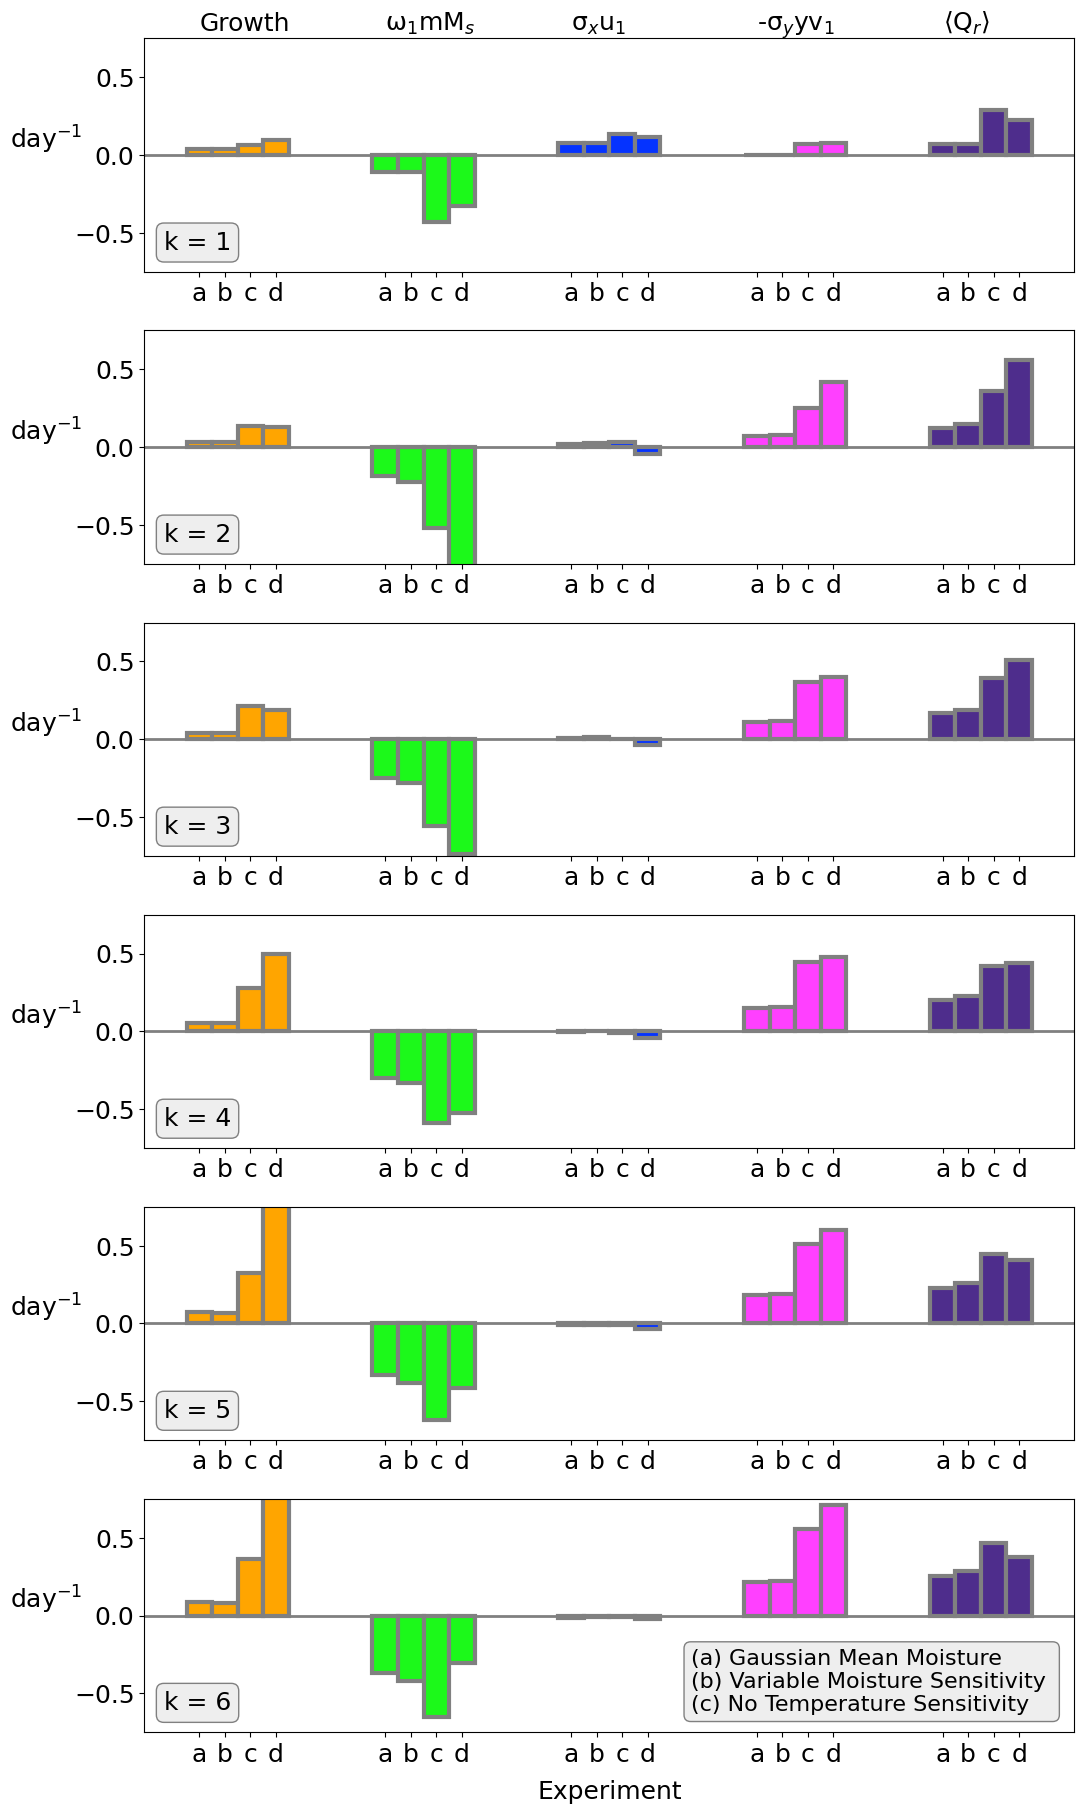

In [60]:
# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']
experiment_labels = f"(a) Gaussian Mean Moisture \n(b) Variable Moisture Sensitivity \n(c) No Temperature Sensitivity"

# bar_labels = [r'Growth', r'ω$_1$mM$_s$ + $\langle$Q$_r$$\rangle$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$']
# bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff']

south_bound = multi_experiment_growth_budgets.attrs['Latitude Bounds'][0]
north_bound = multi_experiment_growth_budgets.attrs['Latitude Bounds'][1]

t = day_to_index(360)

plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(12, 22))
gs_main = gs.GridSpec(6, 1, figure=fig)
gs_main.update(hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs_main[0]))
ax.append(fig.add_subplot(gs_main[1]))
ax.append(fig.add_subplot(gs_main[2]))
ax.append(fig.add_subplot(gs_main[3]))
ax.append(fig.add_subplot(gs_main[4]))
ax.append(fig.add_subplot(gs_main[5]))

for row_index, k in enumerate(multi_experiment_growth_budgets["k"].values):
    width = 0.1375
    multiplier = 0
    x = np.arange(len(bar_labels))
    bar_max = []
    for experiment in multi_experiment_growth_budgets["experiment"].values:
        offset = width * multiplier
        bar_values = [
                SECONDS_PER_DAY*multi_experiment_growth_budgets['growth'].sel(experiment=experiment, k=k).isel(time=t),
                SECONDS_PER_DAY*multi_experiment_growth_budgets['omega'].sel(experiment=experiment, k=k).isel(time=t),
                SECONDS_PER_DAY*multi_experiment_growth_budgets['u'].sel(experiment=experiment, k=k).isel(time=t),
                SECONDS_PER_DAY*multi_experiment_growth_budgets['v'].sel(experiment=experiment, k=k).isel(time=t),
                SECONDS_PER_DAY*multi_experiment_growth_budgets['Qr'].sel(experiment=experiment, k=k).isel(time=t),
            ]
        bar_max.append(np.max(bar_values))
        
        rects = ax[row_index].bar(
            x + offset, 
            bar_values, 
            label = experiment, 
            color = bar_colors, 
            width = width,
            edgecolor='gray', 
            # edgecolor='#bcbcbc', 
            linewidth=3,
            align='center'
        )    
        # ax.bar_label(rects, padding=0.3)
        multiplier += 1

    if row_index == 0:
        for l in range(len(bar_labels)):
            ax[row_index].text(l, 0.8, s=bar_labels[l])
    
    ax[row_index].axhline(y = 0, color='gray', lw=2)
    
    # ax[row_index].set_title(f"k = {k}", pad=10) 
    ax[row_index].text(
        0.021, 0.075, 
        s=f"k = {k}", 
        va='bottom',
        bbox=dict(facecolor="#eeeeee", edgecolor="gray", boxstyle='round'), 
        transform=ax[row_index].transAxes
    )
    ax[row_index].set_ylabel(r'day$^{-1}$', rotation=0, labelpad=20)
    ax[row_index].set_xticklabels([''])
    ax[row_index].set_ylim(-0.75, 0.75)

    ax[row_index].set_xticks(
        # np.concatenate((x, x+offset/2, x+offset)),
        np.concatenate((x, x+offset/3, x+2*offset/3, x+offset)),
        # np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
        # sorted(np.arange(len(bar_labels)*len(experiments_to_load))%len(experiments_to_load)+1)
        np.repeat(['a', 'b', 'c', 'd'], 5)
    )
    
ax[-1].set_xlabel('Experiment', labelpad=10)
ax[-1].text(
    # l-1.2, -1.2*np.max(bar_max), 
    0.5875, 0.075,
    s=experiment_labels, 
    bbox=dict(facecolor="#eeeeee", edgecolor="gray", linewidth=1, boxstyle='round'), 
    transform=ax[-1].transAxes,
    ha='left',
    va='bottom',
    fontsize=16
)

plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_multi-experiment_growth-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Propagation Budgets

In [ ]:
# Label the bars 
bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']
experiment_labels = f"(a) Gaussian Mean Moisture \n(b) Variable Moisture Sensitivity \n(c) No Temperature Sensitivity"

# bar_labels = [r'Propagation', r'ω$_1$mM$_s$ + $\langle$Q$_r$$\rangle$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$']
# bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff']

south_bound = multi_experiment_propagation_budgets.attrs['Latitude Bounds'][0]
north_bound = multi_experiment_propagation_budgets.attrs['Latitude Bounds'][1]

t = day_to_index(360)

plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(12, 22))
gs_main = gs.GridSpec(6, 1, figure=fig)
gs_main.update(hspace=0.25)

ax = []
ax.append(fig.add_subplot(gs_main[0]))
ax.append(fig.add_subplot(gs_main[1]))
ax.append(fig.add_subplot(gs_main[2]))
ax.append(fig.add_subplot(gs_main[3]))
ax.append(fig.add_subplot(gs_main[4]))
ax.append(fig.add_subplot(gs_main[5]))

for row_index, k in enumerate(multi_experiment_propagation_budgets["k"].values):
    width = 0.1375
    multiplier = 0
    x = np.arange(len(bar_labels))
    bar_max = []
    for experiment in multi_experiment_propagation_budgets["experiment"].values:
        offset = width * multiplier
        bar_values = [
                multi_experiment_propagation_budgets['propagation'].sel(experiment=experiment, k=k).isel(time=t),
                multi_experiment_propagation_budgets['omega'].sel(experiment=experiment, k=k).isel(time=t),
                multi_experiment_propagation_budgets['u'].sel(experiment=experiment, k=k).isel(time=t),
                multi_experiment_propagation_budgets['v'].sel(experiment=experiment, k=k).isel(time=t),
                multi_experiment_propagation_budgets['Qr'].sel(experiment=experiment, k=k).isel(time=t),
            ]
        bar_max.append(np.max(bar_values))
        
        rects = ax[row_index].bar(
            x + offset, 
            bar_values, 
            label = exp, 
            color = bar_colors, 
            width = width,
            edgecolor='gray', 
            # edgecolor='#bcbcbc', 
            linewidth=3,
            align='center'
        )    
        # ax.bar_label(rects, padding=0.3)
        multiplier += 1

    if row_index == 0:
        for l in range(len(bar_labels)):
            ax[row_index].text(l, 2.2, s=bar_labels[l])
    
    ax[row_index].axhline(y = 0, color='gray', lw=2)
    
    # ax[row_index].set_title(f"k = {k}", pad=10) 
    ax[row_index].text(
        0.021, 0.075, 
        s=f"k = {k}", 
        va='bottom',
        bbox=dict(facecolor="#eeeeee", edgecolor="gray", boxstyle='round'), 
        transform=ax[row_index].transAxes
    )
    # ax[row_index].set_ylabel(r'day$^{-1}$', rotation=0, labelpad=20)
    ax[row_index].set_xticklabels([''])
    ax[row_index].set_ylim(-2.5, 2)

    ax[row_index].set_xticks(
        np.concatenate((x, x+offset/2, x+offset)),
        # np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
        # sorted(np.arange(len(bar_labels)*len(experiments_to_load))%len(experiments_to_load)+1)
        np.repeat(['a', 'b', 'c'], 5)
    )
    
ax[-1].set_xlabel('Experiment', labelpad=10)
ax[-1].text(
    # l-1.2, -1.2*np.max(bar_max), 
    0.5875, 0.075,
    s=experiment_labels, 
    bbox=dict(facecolor="#eeeeee", edgecolor="gray", linewidth=1, boxstyle='round'), 
    transform=ax[-1].transAxes,
    ha='left',
    va='bottom',
    fontsize=16
)

plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{initial_condition_type}_initial-condition/figures/"
#     + f"{initial_condition_type}-initial-condition_multi-experiment_propagation-budget"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Phase Speeds

In [ ]:
specified_wavenumber = 2
A21_frequencies = np.array([0.103609, 0.181382, 0.265887, 0.356728, 0.453978])
A21_phase_speeds = A21_frequencies/SECONDS_PER_DAY/(np.array([1,2,3,4,5])/EARTH_RADIUS)

south_bound = multi_experiment_phase_speeds.attrs['Latitude Bounds'][0]
north_bound = multi_experiment_phase_speeds.attrs['Latitude Bounds'][1]

grand_max = []
grand_min = []

for index, exp in enumerate(multi_experiment_phase_speeds["experiment"].values):
    grand_max.append(
        multi_experiment_phase_speeds.sel(experiment=exp, k=specified_wavenumber).isel(time=slice(day_to_index(10), day_to_index(360))).max()
    )
    grand_min.append(
        multi_experiment_phase_speeds.sel(experiment=exp, k=specified_wavenumber).isel(time=slice(day_to_index(10), day_to_index(360))).min()
    )

grand_max = np.max(grand_max)
grand_min = np.min(grand_min)

plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))
ax.set_title(f"k = {specified_wavenumber} Phase Speeds", pad=10)
ax.set_title(
    f"k = {specified_wavenumber} instantaneous phase speed over "
    + f"{np.abs(multi_experiment_phase_speeds[index].attrs['Latitude Bounds'][0])}°S"
    + f" - {np.abs(multi_experiment_phase_speeds[index].attrs['Latitude Bounds'][1])}°N", 
    pad=15
)

if specified_wavenumber != 6:
    ax.hlines(y=A21_phase_speeds[specified_wavenumber-1], xmin=0, xmax=360, color='red', label='Ahmed 21') 

for index, exp in enumerate(multi_experiment_phase_speeds["experiment"].values):
    ax.plot(
        downsampled_timepoints/SECONDS_PER_DAY,
        multi_experiment_phase_speeds.sel(experiment=exp, k=specified_wavenumber),
        label=exp,
        color=experiment_colors[exp]
    )

ax.set_xlabel('Days')    
ax.set_ylabel(r'$\frac{m}{s}$', rotation=0, va='center', labelpad=25, fontsize=28)
ax.set_ylim(grand_min-3, grand_max+3)
ax.set_xlim(-5, 365)
ax.legend(loc='best')

plt.show()
# plt.savefig(
#       f"output/Ahmed-21/multi-experiment_figures/Kelvin-wave_initial-condition"
#     + f"_multi-experiment_k={specified_wavenumber}-phase_speeds"
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

In [ ]:
specified_wavenumber = 2
A21_frequencies = np.array([0.103609, 0.181382, 0.265887, 0.356728, 0.453978])
A21_phase_speeds = A21_frequencies/SECONDS_PER_DAY/(np.array([1,2,3,4,5])/EARTH_RADIUS)

south_bound = multi_experiment_phase_speeds.attrs['Latitude Bounds'][0]
north_bound = multi_experiment_phase_speeds.attrs['Latitude Bounds'][1]

fig = plt.figure(figsize=(16,12))
gs_main = gs.GridSpec(3, 2, figure=fig)
gs_main.update(bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.2, wspace=0.1)

ax = []
ax.append(fig.add_subplot(gs_main[0,0]))
ax.append(fig.add_subplot(gs_main[0,1]))
ax.append(fig.add_subplot(gs_main[1,0]))
ax.append(fig.add_subplot(gs_main[1,1]))
ax.append(fig.add_subplot(gs_main[2,0]))
ax.append(fig.add_subplot(gs_main[2,1]))

for index, k in enumerate([1,2,3,4,5,6]):
    # ax[index].set_title(f"k = {k} Phase Speeds", pad=10)
    
    grand_max = []
    grand_min = []
    
    for exp in multi_experiment_phase_speeds["experiment"].values:
        grand_max.append(
            multi_experiment_phase_speeds.sel(experiment=exp, k=k).isel(time=slice(day_to_index(10), day_to_index(360))).max()
        )
        grand_min.append(
            multi_experiment_phase_speeds.sel(experiment=exp, k=k).isel(time=slice(day_to_index(10), day_to_index(360))).min()
        )
    
    grand_max = np.max(grand_max)
    grand_min = np.min(grand_min)
    
    if k != 6:
        ax[index].hlines(y=A21_phase_speeds[index], xmin=0, xmax=360, color='red', label='Ahmed 21') 
    
    for exp_index, exp in enumerate(multi_experiment_phase_speeds["experiment"].values):
        ax[index].plot(
            downsampled_timepoints/SECONDS_PER_DAY,
            multi_experiment_phase_speeds.sel(experiment=exp, k=k),
            label=exp,
            color=experiment_colors[exp]
        )

        # Build a rectangle in axes coords
    left, width = 0.05, 0.9
    bottom, height = 0.05, 0.9
    right = left + width
    top = bottom + height
    
    ax[index].text(
        # x=0.975, 
        # y=0.875, 
        x=right,
        y=top,
        ha='right',
        va='top',
        s=f"k = {k}", 
        # va='center', 
        # ha='right', 
        transform = ax[index].transAxes,
        bbox = dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round'),
        fontsize=20
    )
    ax[index].set_xlabel('Days')    
    if k%2 !=0:
        ax[index].set_ylabel(r'$\frac{m}{s}$', rotation=0, va='center', labelpad=25, fontsize=28)
    # ax[index].set_ylim(grand_min-3, grand_max+3)
    ax[index].set_ylim(-5,25)
    ax[index].set_xlim(-5, 365)
    ax[index].set_aspect('auto')
ax[0].legend(loc='lower left', fontsize=8)

plt.show()
# plt.savefig(
#       f"output/Ahmed-21/multi-experiment_figures/Kelvin-wave_initial-condition"
#     + f"_multi-experiment_k={specified_wavenumber}-phase_speeds"
#     + f"_{mjo.tick_labeller([south_bound], 'lat', False)[0]}-{mjo.tick_labeller([north_bound], 'lat', False)[0]}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Dispersion curves

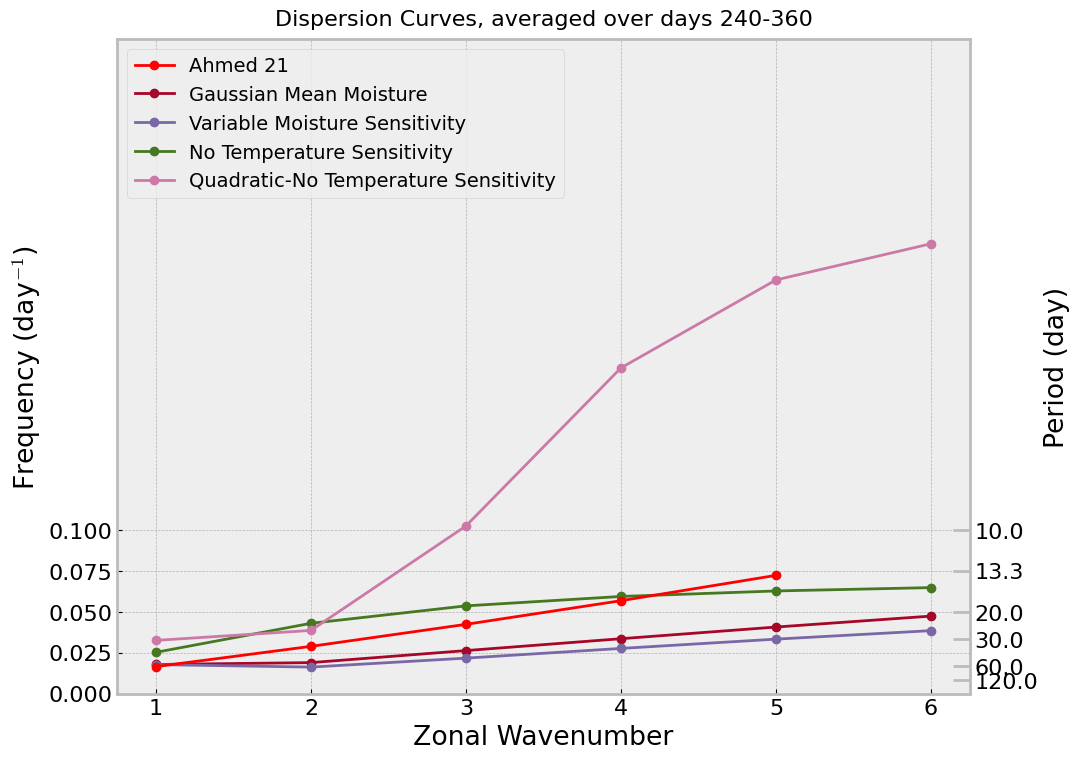

In [63]:
A21_frequencies = [0.103609/(2*np.pi), 0.181382/(2*np.pi), 0.265887/(2*np.pi), 0.356728/(2*np.pi), 0.453978/(2*np.pi)]

# Plot dispersion curves
starting_day = 240
ending_day = 360
starting_index = day_to_index(starting_day)
ending_index = day_to_index(ending_day)

plt.style.use('bmh')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 1, figsize=(11, 8.5))
ax.set_title(f"Dispersion Curves, averaged over days {starting_day}-{ending_day}", pad=10, fontsize=16)

# Plot analytic A21 values
ax.plot([1,2,3,4,5], A21_frequencies, label='Ahmed 21', marker='o', color='red', zorder=10)

for exp_index, exp in enumerate(multi_experiment_phase_speeds['experiment'].values):
    calculated_frequency = []
    for wvnum_index, wvnum in enumerate(multi_experiment_phase_speeds['k'].values):
        calculated_frequency.append(
            np.mean(
                multi_experiment_phase_speeds.sel(experiment=exp, k=wvnum)[starting_index:ending_index]
            )*(wvnum_index+1)/(2*np.pi*EARTH_RADIUS)
        )
    # calculated_frequency.append(phase_speeds[exp][t]*(index+1)/EARTH_RADIUS)

    ax.plot(
        np.array([1,2,3,4,5,6]),
        SECONDS_PER_DAY*np.array(calculated_frequency), 
        marker='o',
        label=exp,
        color=experiment_colors[exp]
    )

ax.set_xlabel('Zonal Wavenumber')
ax.set_xticks(ticks=np.array([1,2,3,4,5,6]), labels=np.array([1,2,3,4,5,6]))
frequency_ticks = np.arange(0, 0.125, 0.025)
ax.set_ylabel(r'Frequency (day$^{-1}$)')
ax.set_yticks(ticks=frequency_ticks)
ax.legend(loc='upper left', fontsize=14)
ax2 = ax.twinx()
ax.get_shared_y_axes().join(ax, ax2)

ax2.set_ylim(0, 0.4)
# period_ticks = [1/120, 1/45, 1/30, 1/20, 1/15, 1/12]
period_ticks = [1/120, 1/60, 1/30, 1/20, 1/13.3, 1/10]
period_tick_labels = [f"{1/tick:0.1f}" for tick in period_ticks]
ax2.set_yticks(ticks=period_ticks, labels=period_tick_labels)
ax2.tick_params(length=12, width=2, color='#bcbcbc')
ax2.grid(False, axis='y')
ax2.set_ylabel('Period (day)')

for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)


plt.show()
# plt.savefig(
#       f"output/Ahmed-21/multi-experiment_figures/Kelvin-wave_initial-condition"
#     + f"_multi-experiment_dispersion-curves-plot_days-{starting_day}-{ending_day}"
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## \<q\>-\<T\>-\<MSE\> slopes

### Calculate slopes

In [12]:
day = 360

south_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - 10).argmin()
north_lat_index = np.abs(output_meridional_gridpoints/METERS_PER_DEGREE - 15).argmin()

experiments_to_load = [
    # 'Base Case',
    'Gaussian Mean Moisture',
    'Variable Moisture Sensitivity',
    'No Temperature Sensitivity'
]

multi_experiment_moisture_slope = xr.DataArray(
    data=np.empty((len(experiments_to_load), 6, len(downsampled_timepoints))),
    dims=["experiment", "k", "time"],
    coords={
        "experiment" : experiments_to_load,
        "k" : [1,2,3,4,5,6],
        "time" : downsampled_timepoints
    },
    attrs = {
        "day" : day
    }
)
multi_experiment_temperature_slope = xr.DataArray(
    data=np.empty((len(experiments_to_load), 6, len(downsampled_timepoints))),
    dims=["experiment", "k", "time"],
    coords={
        "experiment" : experiments_to_load,
        "k" : [1,2,3,4,5,6],
        "time" : downsampled_timepoints
    },
    attrs = {
        "day" : day
    }
)

multi_experiment_max_value_ratio = xr.DataArray(
    data=np.empty((len(experiments_to_load), 6, len(downsampled_timepoints))),
    dims=["experiment", "k", "time"],
    coords={
        "experiment" : experiments_to_load,
        "k" : [1,2,3,4,5,6],
        "time" : downsampled_timepoints
    },
    attrs = {
        "day" : day
    }
)

for exp_index, experiment in enumerate(experiments_to_load):
    for k_index, k in enumerate([1,2,3,4,5,6]):
        specified_output_file_directory = f"output/Ahmed-21/{experiments_table[experiment]}"
        specified_initial_condition_name = f"k={k}.0_m=1_Kelvin-wave"
        initial_condition_type = specified_initial_condition_name.split('_')[-1]

        loaded_data = xr.load_dataset(
            f"{specified_output_file_directory}/Kelvin-wave_initial-condition/"
            + f"{specified_initial_condition_name}" 
            + f"_downsampled-model-data_compiled.nc"
        )

        multi_experiment_max_value_ratio[exp_index, k_index] = (loaded_data["q"].max(dim=["y", "x"])/loaded_data["T"].max(dim=["y", "x"])).values

        for day_index, day in enumerate(range(len(downsampled_timepoints))):
            loaded_moisture_data = loaded_data['q'].isel(y=slice(south_lat_index, north_lat_index), time = day_to_index(day)).values.flatten()
            loaded_temperature_data = loaded_data['T'].isel(y=slice(south_lat_index, north_lat_index), time = day_to_index(day)).values.flatten()
            column_MSE = loaded_moisture_data + loaded_temperature_data
    
            calculated_moisture_slope, calculated_moisture_intercept, _, _, _ = sp.stats.linregress(
                column_MSE,
                loaded_moisture_data
            )
    
            calculated_temperature_slope, calculated_temperature_intercept, _, _, _ = sp.stats.linregress(
                column_MSE,
                loaded_temperature_data
            )
            
            multi_experiment_moisture_slope[exp_index, k_index, day_index] = calculated_moisture_slope
            multi_experiment_temperature_slope[exp_index, k_index, day_index] = calculated_temperature_slope

print("done")

done


### Plot slopes as bar graphs

In [ ]:
# Label the bars 
bar_labels = experiments_to_load
bar_colors = [experiment_colors[experiment] for experiment in experiments_to_load]

day = 360

plt.style.use('bmh')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16, 10))
gs_main = gs.GridSpec(2, 1, figure=fig)
gs_main.update(left=0.05, right=0.95, bottom=0.05, top=0.875, hspace=0.2)

fig.suptitle(t=r"Slope of quantities vs. $\langle$MSE$\rangle$, day" +f" {day}, all latitudes", x=0.5, y=0.975)
ax = []
ax.append(fig.add_subplot(gs_main[0]))
ax.append(fig.add_subplot(gs_main[1]))

# width = 0.1375
width = 0.1175
multiplier = 0
x = np.arange(len(bar_labels))

bar_max = []
for k in multi_experiment_moisture_slope["k"]:
    bar_values = []
    offset = width * multiplier
    for experiment in experiments_to_load:
        bar_values.append(multi_experiment_moisture_slope.sel(experiment=experiment, k=k).isel(time=day_to_index(day)))
    bar_max.append(np.max(bar_values))
    
    rects = ax[0].bar(
        x + offset, 
        bar_values, 
        label = bar_labels, 
        color = bar_colors, 
        width = width,
        edgecolor='#bcbcbc', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

for l in range(len(bar_labels)):
    ax[0].text(l, 1.22*np.max(bar_max), s=bar_labels[l])

ax[0].set_xticks(
    np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
    sorted(np.arange(len(bar_labels)*6)%6+1)
)
# ax[0].set_xlabel('Zonal Wavenumber', labelpad=10)
ax[0].set_ylabel(r'$\langle$q$\rangle$', rotation=0, va='center', labelpad=25)
ax[0].set_ylim(0, 1)
ax[0].xaxis.grid(color='#bcbcbc', ls=':', lw=1, alpha=1)
ax[0].grid(False, axis='x')
ax[0].tick_params(axis='both', which='major', pad=7.5)

# width = 0.1375
width = 0.1175
multiplier = 0
x = np.arange(len(bar_labels))

bar_max = []
for k in multi_experiment_temperature_slope["k"]:
    offset = width * multiplier
    bar_values = []
    for experiment in experiments_to_load:
        bar_values.append(multi_experiment_temperature_slope.sel(experiment=experiment, k=k).isel(time=day_to_index(360)))
    bar_max.append(np.max(bar_values))
    
    rects = ax[1].bar(
        x + offset, 
        bar_values, 
        label = experiments_to_load[0], 
        color = bar_colors, 
        width = width,
        edgecolor='#bcbcbc', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

# for l in range(len(bar_labels)):
#     ax[1].text(l, 1.2*np.max(bar_max), s=bar_labels[l])

ax[1].set_xticks(
    np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
    sorted(np.arange(len(bar_labels)*6)%6+1)
)
ax[1].set_xlabel('Zonal Wavenumber', labelpad=10)
ax[1].set_ylabel(r'$\langle$T$\rangle$', rotation=0, va='center', labelpad=25)
ax[1].set_ylim(0, 1)
ax[1].xaxis.grid(color='#bcbcbc', ls=':', lw=1, alpha=1)
ax[1].grid(False, axis='x')
ax[1].tick_params(axis='y', which='major', pad=7.5, length=8, width=2, color='#bcbcbc')

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

plt.show()
# plt.savefig(
#       f"output/Ahmed-21/multi-experiment_figures/"
#     + f"{initial_condition_type}-initial-condition_multi-experiment_slopes"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

## Plot epsq/epst ratio as bar graphs

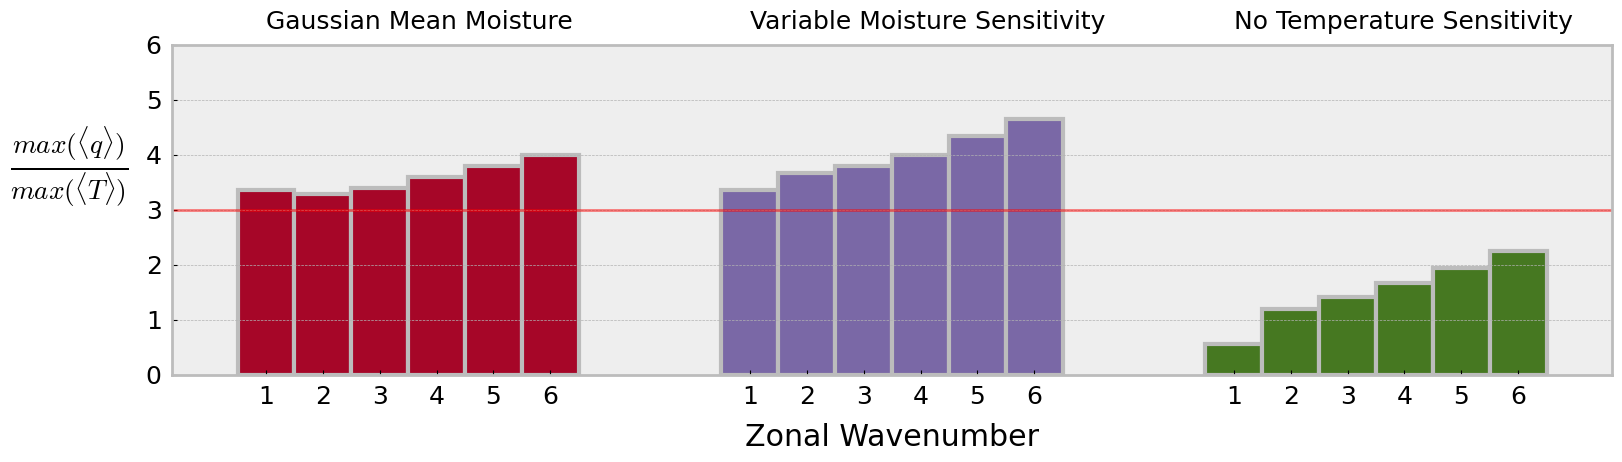

In [45]:
# Label the bars 
bar_labels = experiments_to_load
bar_colors = [experiment_colors[experiment] for experiment in experiments_to_load]

day = 360

plt.style.use('bmh')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16, 4))
gs_main = gs.GridSpec(1, 1, figure=fig)
gs_main.update(left=0.05, right=0.95, bottom=0.05, top=0.875)

# fig.suptitle(t=r"Slope of quantities vs. $\langle$MSE$\rangle$, day" +f" {day}, all latitudes", x=0.5, y=0.975)
ax = []
ax.append(fig.add_subplot(gs_main[0]))
# ax.append(fig.add_subplot(gs_main[1]))

# width = 0.1375
width = 0.1175
multiplier = 0
x = np.arange(len(bar_labels))

bar_max = []
for k in multi_experiment_max_value_ratio["k"]:
    bar_values = []
    offset = width * multiplier
    for experiment in experiments_to_load:
        bar_values.append(multi_experiment_max_value_ratio.sel(experiment=experiment, k=k).isel(time=day_to_index(day)))
    bar_max.append(np.max(bar_values))
    
    rects = ax[0].bar(
        x + offset, 
        bar_values, 
        label = bar_labels, 
        color = bar_colors, 
        width = width,
        edgecolor='#bcbcbc', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

for l in range(len(bar_labels)):
    ax[0].text(l, 1.35*np.max(bar_max), s=bar_labels[l])

ax[0].set_xticks(
    np.concatenate((x, x+offset/5, x+2*offset/5, x+3*offset/5, x+4*offset/5, x+offset)),
    sorted(np.arange(len(bar_labels)*6)%6+1)
)
ax[0].set_xlabel('Zonal Wavenumber', labelpad=10)
# ax[0].set_ylabel(r'$\langle$q$\rangle$', rotation=0, va='center', labelpad=25)
ax[0].set_ylim(0, 6)
ax[0].xaxis.grid(color='#bcbcbc', ls=':', lw=1, alpha=1)
ax[0].grid(False, axis='x')
ax[0].tick_params(axis='both', which='major', pad=7.5)

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)

ax[0].axhline(y = 3, color='red', alpha=0.5)
ax[0].set_ylabel(r'$\frac{max(\langle q \rangle)}{max(\langle T \rangle)}$', rotation=0, labelpad=55, fontsize=28)

plt.show()
# plt.savefig(
#       f"output/Ahmed-21/multi-experiment_figures/"
#     + f"{initial_condition_type}-initial-condition_multi-experiment_slopes"
#     + f"_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days"    
#     + (f"_{time.strftime('%Y%m%d-%H%M')}" if save_timestamp else '')
#     + f".png", 
#     bbox_inches='tight'
# )

In [49]:
multi_experiment_max_value_ratio = xr.DataArray(
    data=np.empty((len(experiments_to_load), 6, len(downsampled_timepoints))),
    dims=["experiment", "k", "time"],
    coords={
        "experiment" : experiments_to_load,
        "k" : [1,2,3,4,5,6],
        "time" : downsampled_timepoints
    },
    attrs = {
        "day" : day
    }
)

for exp_index, experiment in enumerate(experiments_to_load):
    for k_index, k in enumerate([1,2,3,4,5,6]):
        specified_output_file_directory = f"output/Ahmed-21/{experiments_table[experiment]}"
        specified_initial_condition_name = f"k={k}.0_m=1_Kelvin-wave"
        initial_condition_type = specified_initial_condition_name.split('_')[-1]

        loaded_data = xr.load_dataset(
            f"{specified_output_file_directory}/Kelvin-wave_initial-condition/"
            + f"{specified_initial_condition_name}" 
            + f"_downsampled-model-data_compiled.nc"
        )

        multi_experiment_max_value_ratio[exp_index, k_index] = (loaded_data["q"].max(dim=["y", "x"])/loaded_data["T"].max(dim=["y", "x"])).values

    print(loaded_data["q"][day_to_index(180)].max(dim=["y", "x"]).values)
    print(loaded_data["T"][day_to_index(180)].max(dim=["y", "x"]).values)


567793634.5889033
142311377.06893831
384628056.4884475
82560849.74453534
8.308485999879846e+29
3.7071249877228505e+29


In [50]:
567793634.5889033/142311377.06893831

3.9897979085245825

In [51]:
8.308485999879846e+29/3.7071249877228505e+29

2.2412208995908283

In [52]:
567793634.5889033/8.308485999879846e+29

6.833900118470616e-22